<a href="https://colab.research.google.com/github/dcthyun0308/ESAA/blob/main/YB_%EB%B0%A9%ED%95%99%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%ED%86%B5%ED%95%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
# 2. matplotlib 캐시 삭제 (기존 폰트 리스트를 초기화해야 나눔고딕을 인식함)
!rm -rf ~/.cache/matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train = pd.read_csv('/content/drive/MyDrive/ESAA/YB_V/train.csv')
sub = pd.read_csv('/content/drive/MyDrive/ESAA/YB_V/sample_submission.csv')

In [5]:
train.head()

,영업일자,영업장명_메뉴명,매출수량
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102676 entries, 0 to 102675
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   영업일자      102676 non-null  object
 1   영업장명_메뉴명  102676 non-null  object
 2   매출수량      102676 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ MB


In [7]:
DATE_COL   = '영업일자'
TARGET_COL = '매출수량'
KEY_COLS   = ['영업장명', '메뉴명']

In [8]:
# 첫번째 '_' 기준으로 분리
train[KEY_COLS] = train['영업장명_메뉴명'].str.split('_', n=1, expand=True)

In [9]:
train.head()

,영업일자,영업장명_메뉴명,매출수량,영업장명,메뉴명
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트


In [10]:
# 영업장 종류
sorted(train['영업장명'].unique())

['느티나무 셀프BBQ', '담하', '라그로타', '미라시아', '연회장', '카페테리아', '포레스트릿', '화담숲주막', '화담숲카페']

In [11]:
# 영업장별 데이터 수
train['영업장명'].value_counts()

,count
영업장명,
담하,22344
미라시아,16492
라그로타,13300
카페테리아,12768
느티나무 셀프BBQ,12236
연회장,12236
포레스트릿,6384
화담숲주막,4256
화담숲카페,2660


In [12]:
train.isnull().sum().sort_values(ascending=False)

,0
영업일자,0
영업장명_메뉴명,0
매출수량,0
영업장명,0
메뉴명,0


In [13]:
train.dtypes

,0
영업일자,object
영업장명_메뉴명,object
매출수량,int64
영업장명,object
메뉴명,object


In [14]:
train['영업일자'] = pd.to_datetime(train['영업일자'])

In [15]:
train['매출수량'].describe()

,매출수량
count,102676.000000
mean,10.653083
std,41.887692
min,-80.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,1372.000000


- min: -80 -> 음수 존재
- 50%: 0 -> 전체 데이터 절반 이상이 0
- max: 1372 -> median 대비 과도하게 큼
- std: 41.9 -> mean 대비 과도하게 큼
- --> 이벤트/단체/특정 일자 폭증 존재

In [16]:
# 음수 개수 확인
(train['매출수량'] < 0).sum()

np.int64(14)

In [17]:
# 영업장별 0 비율
(train.groupby('영업장명')['매출수량'].apply(lambda x: (x == 0).mean()).sort_values(ascending=False))

,매출수량
영업장명,
연회장,0.660919
느티나무 셀프BBQ,0.601422
라그로타,0.597594
미라시아,0.519888
화담숲카페,0.473684
화담숲주막,0.470865
담하,0.469298
카페테리아,0.441024
포레스트릿,0.420583


In [18]:
# 영업장별 음수 개수
(train.query('매출수량 < 0').groupby('영업장명').size().sort_values(ascending=False))

,0
영업장명,
포레스트릿,5
연회장,4
느티나무 셀프BBQ,2
미라시아,2
카페테리아,1


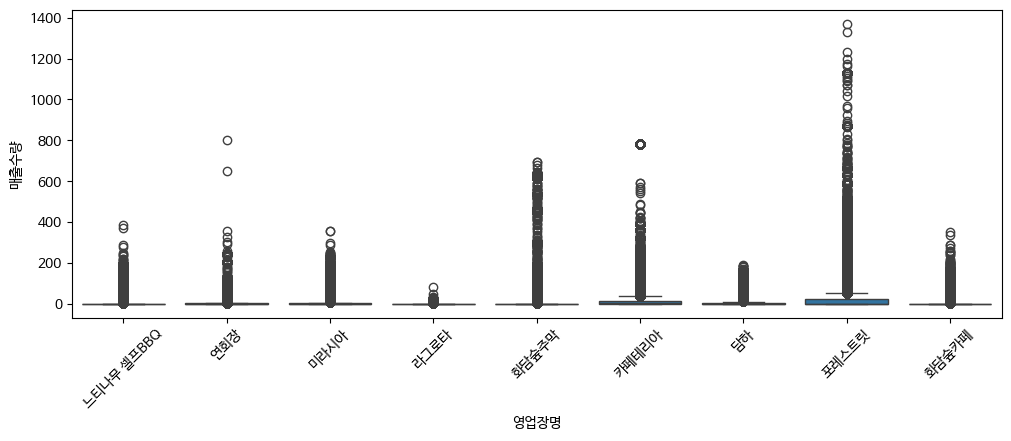

In [73]:
# 업장별 이상치 확인
plt.figure(figsize=(12,4))
sns.boxplot(data=train, x='영업장명', y='매출수량')
plt.xticks(rotation=45)
plt.show()

- 이상치가 과도하게 많음 X
- 분포 자체가 대부분의 날에는 아예 안 팔리거나 조금만 팔리는데, 가끔씩 엄청 크게 팔리는 날이 있는 구조

- 포레스트릿: 상단 점이 제일 높고(최대 1300대), 스파이크가 가장 큼

- 화담숲주막/카페: 600~700대 스파이크 존재

- 연회장: 0 비율도 높고(0.66), 스파이크도 있음 → “행사/단체” 느낌

- 나머지는 상대적으로 낮지만 그래도 outlier 점이 많이 보임

In [20]:
# 음수 -> 0
train.loc[train['매출수량'] < 0, '매출수량'] = 0

# *기본 날짜 피처 생성*

In [21]:
train['요일'] = train['영업일자'].dt.dayofweek
train['연도'] = train['영업일자'].dt.year
train['월'] = train['영업일자'].dt.month
train['일'] = train['영업일자'].dt.day
train['주'] = train['영업일자'].dt.isocalendar().week.astype(int)

# *공휴일 파생변수*

In [22]:
import pandas as pd

# 1. 날짜 데이터 형식 변환
train['영업일자'] = pd.to_datetime(train['영업일자'])

# 2. 기본 날짜 피처 추출
train['요일'] = train['영업일자'].dt.dayofweek
train['월'] = train['영업일자'].dt.month
train['일'] = train['영업일자'].dt.day
train['주'] = train['영업일자'].dt.isocalendar().week.astype(int)

# 3. 주말 여부 생성 (질문자님의 이전 로직에 맞춰 금/토/일을 주말로 설정하려면 >= 4)
# 일반적인 주말(토/일) 기준이라면 >= 5를 유지하세요.
train['주말여부'] = (train['요일'] >= 4).map({True: '주말', False: '주중'})

# 4. 공휴일 설정 (양력)
holis = ['01-01', '03-01', '05-05', '06-06', '08-15', '10-03', '10-09', '12-25']
train['공휴일여부'] = train['영업일자'].dt.strftime('%m-%d').isin(holis).astype(int)

# 5. 음력 공휴일 설정 (2023-2024)
lunar_holidays = [
    '2023-01-21', '2023-01-22', '2023-01-23',
    '2023-09-28', '2023-09-29', '2023-09-30',
    '2024-02-09', '2024-02-10', '2024-02-11',
]
train['음력공휴일여부'] = train['영업일자'].dt.strftime('%Y-%m-%d').isin(lunar_holidays).astype(int)

# 6. 대체 및 기타 공휴일 설정
substitute_holidays = [
    '2023-01-24', '2023-05-29', '2023-10-02',
    '2024-02-12', '2024-04-10', '2024-05-06'
]
train['대체공휴일여부'] = train['영업일자'].dt.strftime('%Y-%m-%d').isin(substitute_holidays).astype(int)

# 7. 전체 공휴일 통합 (하나라도 해당하면 1)
train['전체공휴일여부'] = ((train['공휴일여부'] == 1) |
                         (train['음력공휴일여부'] == 1) |
                         (train['대체공휴일여부'] == 1)).astype(int)

# 확인용
print(train[['영업일자', '요일', '주말여부', '전체공휴일여부']].head())

        영업일자  요일 주말여부  전체공휴일여부
0 2023-01-01   6   주말        1
1 2023-01-02   0   주중        0
2 2023-01-03   1   주중        0
3 2023-01-04   2   주중        0
4 2023-01-05   3   주중        0


#EDA

##1. 업장별

In [23]:
# 업장별 상위 1% 기준치(스파이크 강도) 보기
train.groupby('영업장명')['매출수량'].quantile(0.99).sort_values(ascending=False)

,매출수량
영업장명,
포레스트릿,627.17
화담숲주막,476.60
카페테리아,190.33
화담숲카페,184.82
느티나무 셀프BBQ,110.00
미라시아,110.00
담하,66.57
연회장,44.00
라그로타,11.00


In [24]:
# 업장별 상위 10개 뽑아서 날짜/메뉴 확인
top_outliers = (
    train.sort_values('매출수량', ascending=False)
         .loc[:, ['영업일자','영업장명','메뉴명','매출수량']]
         .head(50)
)
top_outliers

,영업일자,영업장명,메뉴명,매출수량
89753,2024-01-13,포레스트릿,꼬치어묵,1372
89767,2024-01-27,포레스트릿,꼬치어묵,1329
89760,2024-01-20,포레스트릿,꼬치어묵,1235
90299,2024-01-27,포레스트릿,떡볶이,1200
90285,2024-01-13,포레스트릿,떡볶이,1174
89410,2023-02-04,포레스트릿,꼬치어묵,1165
89398,2023-01-23,포레스트릿,꼬치어묵,1130
89746,2024-01-06,포레스트릿,꼬치어묵,1114
89403,2023-01-28,포레스트릿,꼬치어묵,1107
89733,2023-12-24,포레스트릿,꼬치어묵,1094


- 포레스트릿: 꼬치어묵, 떡볶이, 생수

- 날짜: 주말/특정 시즌(1월, 연말, 겨울)

- 메뉴/업장 반복적으로 등장

- --> 구조적 대량 판매일 가능성 높음 --> 이상치 제거 하지 않음

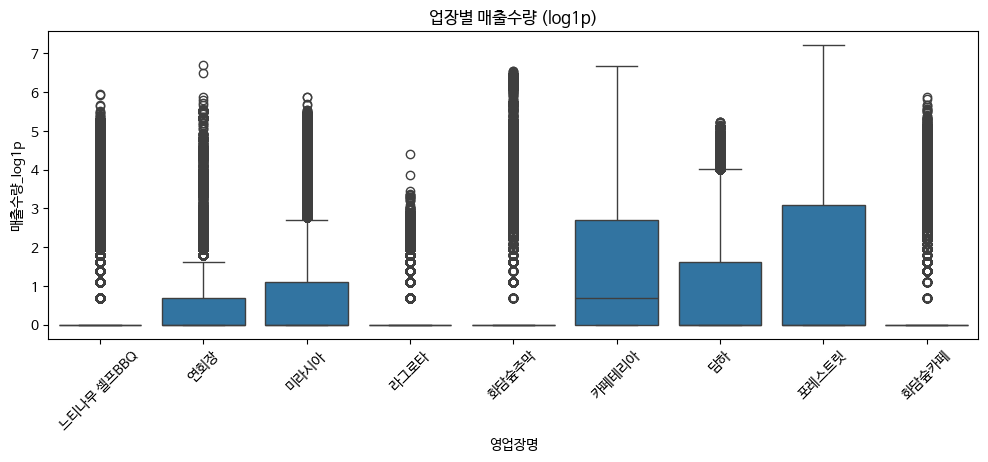

In [74]:
# 박스플롯 log 스케일로 다시 그리기
train['매출수량_log1p'] = np.log1p(train['매출수량'])

plt.figure(figsize=(12,4))
sns.boxplot(data=train, x='영업장명', y='매출수량_log1p')
plt.xticks(rotation=45)
plt.title('업장별 매출수량 (log1p)')
plt.show()

In [26]:
# 업장-메뉴별 얼마나 잘 팔리는지(활성화율)
menu_activity = (
    train.groupby(['영업장명','메뉴명'])['매출수량']
         .apply(lambda x: (x > 0).mean())
         .reset_index(name='sell_rate')
)

menu_activity.sort_values('sell_rate').head(10)

# 0 -> 1 잘 팔림

,영업장명,메뉴명,sell_rate
24,담하,(단체) 생목살 김치전골 2.0,0.133459
46,담하,명인안동소주,0.146617
48,담하,문막 복분자 칵테일,0.146617
25,담하,(단체) 은이버섯 갈비탕,0.157895
72,라그로타,모둠 해산물 플래터,0.157895
95,미라시아,공깃밥,0.163534
159,카페테리아,진사골 설렁탕,0.167293
23,담하,(단체) 공깃밥,0.174812
114,미라시아,잭 애플 토닉,0.186090
137,연회장,마라샹궈,0.197368


In [27]:
# 업장-메뉴별 스케일 차이
menu_scale = (
    train.groupby(['영업장명','메뉴명'])['매출수량']
         .agg(['mean','median','max','std'])
         .reset_index()
)

menu_scale.sort_values('max', ascending=False).head(10)

,영업장명,메뉴명,mean,median,max,std
168,포레스트릿,꼬치어묵,129.203008,1.0,1372,250.098595
169,포레스트릿,떡볶이,106.065789,2.0,1200,207.254780
171,포레스트릿,생수,77.904135,6.0,896,149.379786
132,연회장,Regular Coffee,14.193609,0.0,800,56.009803
158,카페테리아,오픈푸드,10.990602,0.0,780,58.534889
187,화담숲주막,해물파전,113.018797,22.0,695,177.150706
175,포레스트릿,치즈 핫도그,57.150376,4.0,627,100.027378
147,카페테리아,단체식 18000(신),50.095865,0.0,570,96.124195
146,카페테리아,단체식 13000(신),39.067669,0.0,553,82.073867
178,포레스트릿,코카콜라,41.426692,2.0,518,83.431876


- 데이터 수는 '담하', '미라시아'가 제일 많음, 그러나 값이 작고 안정적임
특이 패턴: 포레스트릿, 화담숲주막, 화담숲카페 + 카페테리아

- 일반 식음 업장: 담하, 미라시아, 라그로타, 느티나무 셀프BBQ -> 비교적 안정적, 스케일 작음

- 관광지/유동형 업장: 포레스트릿, 화담숲 주막, 화담숲 카페, 카페테리아 -> 0 많음, 대량 폭증

# *파생변수*(바로밑셀)

In [28]:
# 업장 유형 파생변수 생성(범주형)
flow_stores = ['포레스트릿', '화담숲주막', '화담숲카페', '카페테리아']

train['store_type'] = np.where(
    train['영업장명'].isin(flow_stores),
    'flow',      # 유동형
    'normal'     # 일반 식음
)

In [29]:
train['store_type'].value_counts()

,count
store_type,
normal,76608
flow,26068


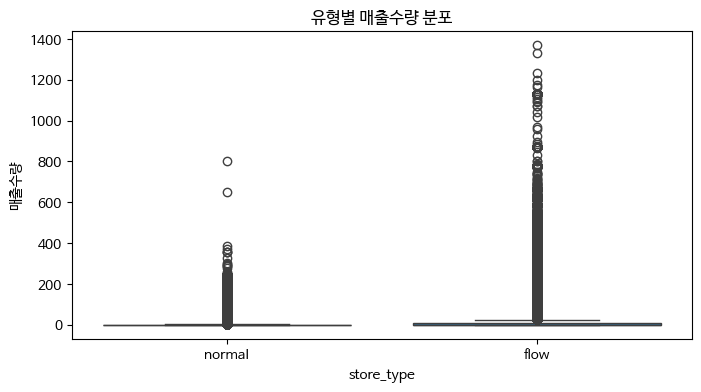

In [75]:
# 유형별 분포 확인
plt.figure(figsize=(8,4))
sns.boxplot(data=train, x='store_type', y='매출수량')
plt.title('유형별 매출수량 분포')
plt.show()

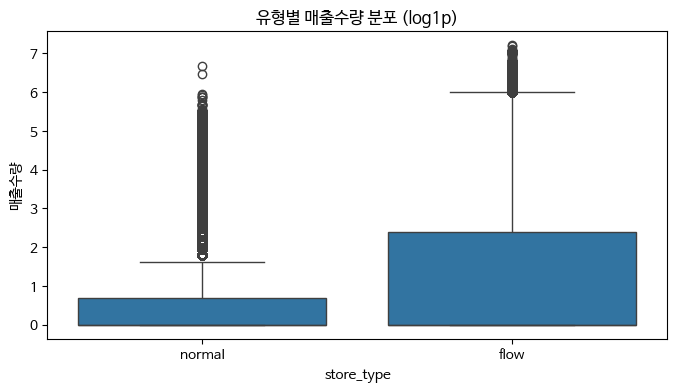

In [76]:
# log 스케일로 확인
plt.figure(figsize=(8,4))
sns.boxplot(
    data=train,
    x='store_type',
    y=np.log1p(train['매출수량'])
)
plt.title('유형별 매출수량 분포 (log1p)')
plt.show()

# *밑 셀 6개 전부 파생변수(타깃변환, 메뉴X업장 기준 lag 변수, Rolling 평균/표준편차, 스파크 감지(지난주 대비 증감))*

In [32]:
# 타깃 변환
train['매출수량_log1p'] = np.log1p(train['매출수량'])

In [33]:
# 메뉴 활동성
menu_sell_rate = (
    train.groupby(['영업장명','메뉴명'])['매출수량']
         .apply(lambda x: (x > 0).mean())
         .reset_index(name='sell_rate')
)

train = train.merge(menu_sell_rate, on=['영업장명','메뉴명'], how='left')

In [34]:
# 메뉴X업장 기준 lag 변수
group_cols = ['영업장명', '메뉴명']
target = '매출수량'

for lag in [1, 7, 14]:
    train[f'lag_{lag}'] = (
        train
        .groupby(group_cols)[target]
        .shift(lag)
    )

In [35]:
# 단기 노이즈 제거 + 추세 반영
# Rolling 평균
for win in [3, 7, 14]:
    train[f'roll_{win}_mean'] = (
        train
        .groupby(group_cols)[target]
        .shift(1)
        .rolling(win)
        .mean()
    )

In [36]:
# Rolling 표준편차
train['roll_7_std'] = (
    train
    .groupby(group_cols)[target]
    .shift(1)
    .rolling(7)
    .std()
)

In [37]:
# 스파이크 감지(지난주 대비 증감)
train['diff_1'] = train['lag_1'] - train['lag_7']

##2. 메뉴별

In [38]:
menu = np.unique(train['영업장명_메뉴명'])
menu

array(['느티나무 셀프BBQ_1인 수저세트', '느티나무 셀프BBQ_BBQ55(단체)',
       '느티나무 셀프BBQ_대여료 30,000원', '느티나무 셀프BBQ_대여료 60,000원',
       '느티나무 셀프BBQ_대여료 90,000원', '느티나무 셀프BBQ_본삼겹 (단품,실내)',
       '느티나무 셀프BBQ_스프라이트 (단체)', '느티나무 셀프BBQ_신라면', '느티나무 셀프BBQ_쌈야채세트',
       '느티나무 셀프BBQ_쌈장', '느티나무 셀프BBQ_육개장 사발면', '느티나무 셀프BBQ_일회용 소주컵',
       '느티나무 셀프BBQ_일회용 종이컵', '느티나무 셀프BBQ_잔디그늘집 대여료 (12인석)',
       '느티나무 셀프BBQ_잔디그늘집 대여료 (6인석)', '느티나무 셀프BBQ_잔디그늘집 의자 추가',
       '느티나무 셀프BBQ_참이슬 (단체)', '느티나무 셀프BBQ_친환경 접시 14cm',
       '느티나무 셀프BBQ_친환경 접시 23cm', '느티나무 셀프BBQ_카스 병(단체)',
       '느티나무 셀프BBQ_콜라 (단체)', '느티나무 셀프BBQ_햇반', '느티나무 셀프BBQ_허브솔트',
       '담하_(단체) 공깃밥', '담하_(단체) 생목살 김치전골 2.0', '담하_(단체) 은이버섯 갈비탕',
       '담하_(단체) 한우 우거지 국밥', '담하_(단체) 황태해장국 3/27까지', '담하_(정식) 된장찌개',
       '담하_(정식) 물냉면 ', '담하_(정식) 비빔냉면', '담하_(후식) 된장찌개', '담하_(후식) 물냉면',
       '담하_(후식) 비빔냉면', '담하_갑오징어 비빔밥', '담하_갱시기', '담하_공깃밥', '담하_꼬막 비빔밥',
       '담하_느린마을 막걸리', '담하_담하 한우 불고기', '담하_담하 한우 불고기 정식', '담하_더덕 한우 지짐',
       '담하_들깨 양지탕', '담하_라면사리', '담하_룸 이용료', '

/tmp/ipython-input-1084604293.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_food_subcat, x='최종_Sub', y='매출수량', palette='viridis')



Aggregated Data:
     최종_Sub     매출수량
0    세트/코스류  4222682
1       튀김류  2276229
2   사이드/소스류  1718421
3       분식류  1606502
4   국/탕/찌개류  1595569
5        밥류  1525175
6       구이류  1242851
7        면류  1216474
8     전/부침류   779358
9       옵션류   409184
10     디저트류   382652
11       찜류    10011
12   패스트푸드류     8599


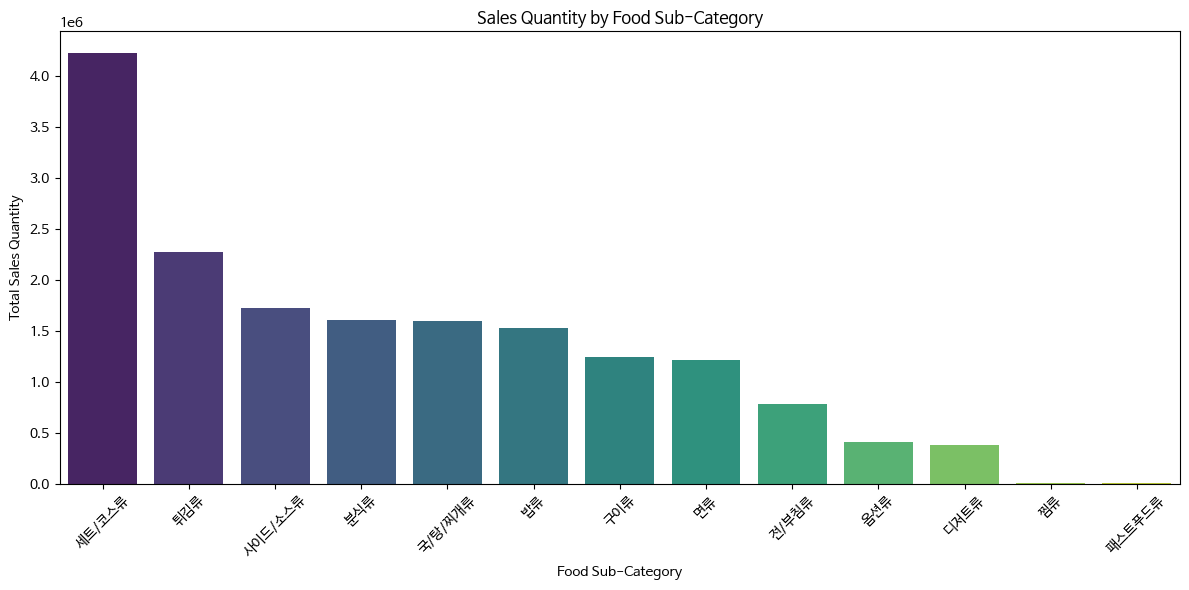

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 1. Define the Keywords and Functions as provided
menu_axis_keywords = {
    "음식": {
        "밥류": ["비빔밥","국밥","덮밥","볶음밥","주먹밥","공깃밥","돌솥","밥","햇반"],
        "면류": ["라면","우동","냉면","비빔냉면","파스타","스파게티","짜장","짬뽕",
                "까르보나라","알리오","메밀","면","사리","리조또","투움바","칼국수"],
        "국/탕/찌개류": ["찌개","탕","전골","해장국","갱시기","국","육개장","마라","스튜",
                       "설렁탕","갈비탕","미역국"],
        "구이류": ["구이","스테이크","갈비","삼겹","목살","한우","aus","고기","해산물",
                  "치킨","오븐구이","바비큐","BBQ","양갈비","불고기"],
        "튀김류": ["돈까스","핫도그","소시지","튀김","치킨너겟","까스"],
        "전/부침류": ["파전","전","부침"],
        "찜류": ["찜","찜닭","떡갈비","계란찜","닭발"],
        "볶음류": ["볶음","볶음밥","샹궈"],
        "패스트푸드류": ["피자","햄버거","핫도그","샌드위치"],
        "세트/코스류": ["정식","플래터","platter","모둠","세트","코스","패키지",
                      "단체","브런치","open food","Open Food","오픈푸드"],
        "디저트류": ["아이스크림","붕어빵","와플","케이크","쿠키","빙수","빵","디저트",
                   "현미뻥스크림","뻥스크림","cookie","후식","푸딩"],
        "사이드/소스류": ["쌈장","솔트","치즈","김치","레몬","야채","어묵","꼬치어묵",
                        "파무침","무침","소스","재료","샐러드","추가","토핑"],
        "분식류": ["떡볶이","순대","튀김우동","라볶이"]
    },
    "음료": {
        "주류": ["소주","막걸리","맥주","와인","하이볼","칵테일",
                "참이슬","처음처럼","카스","테라","버드와이저","하이네켄",
                "스텔라","복분자","명인안동소주",
                "병맥","맥주병","beer","gls","글라스와인",
                "미션서드카베르네쉬라","미션 서드 카베르네 쉬라"],
        "커피류": ["커피","아메리카노","라떼","regularcoffee","regular coffee","coffee","샷","에스프레소"],
        "차류": ["차","얼그레이","tea","홍차","녹차","유자차"],
        "과일/논알콜": ["에이드","주스","스무디","식혜","미숫가루","아이스티",
                       "무알콜","nonalcohol","nonalc",
                       "복숭아","자몽","애플망고","레몬","핑크레몬","유자","매실","토닉워터"],
        "탄산음료": ["콜라","코카콜라","제로콜라","사이다","스프라이트",
                    "토닉","coke","cola","sprite","zero"],
        "생수": ["생수","물","워터","water","mineral"]
    },
    "용품/대여": {
        "도구류": ["컵","종이컵","접시","수저","잔","접시세트","소주컵","일회용컵","식기","플레이트"],
        "가구류": ["테이블","의자","의자 추가","테이블 추가"],
        "대여류": ["대여","보증금","이용권","대관","단체","BBQ55","g-charge","대여료"],
        "공간/홀": ["홀","룸","ballroom","conference","hall","opus","잔디그늘집",
                   "grand ballroom","convention hall"]
    },
}

# 음식 카테고리만 확인.
def detect_food_subcat(name: str) -> str:
    name = name.lower()
    for subcat, keywords in menu_axis_keywords["음식"].items():
        if any(kw.lower() in name for kw in keywords):
            return subcat
    return "기타"

# 메뉴 이름에 사전에 있는 키워드가 있는지 단순 비교
def classify_menu(menu_name: str):
    name = str(menu_name).lower().strip()
    for top, subcats in menu_axis_keywords.items():
        for sub, keywords in subcats.items():
            if any(kw.lower() in name for kw in keywords):
                return top, sub
    return "기타", "기타"

# 단순 키워드 매칭의 오류 잡기
def refine_menu_category(menu_name, top_cat, sub_cat):
    name = str(menu_name)
    if "소주컵" in name or "종이컵" in name:
        return "용품/대여", "도구류"
    if "의자" in name or "테이블" in name:
        return "용품/대여", "가구류"
    if any(k in name for k in ["추가","사리","곁들임"]):
        return "음식", "옵션류"
    if "단체" in name:
        sub = detect_food_subcat(name)
        if sub != "기타":
            return "음식", sub
        return "음식", "세트/코스류"
    food_priority = ["냉면","리조또","찌개","전골","파전","스튜","스파게티","피자"]
    if any(k in name for k in food_priority):
        return "음식", detect_food_subcat(name)
    return top_cat, sub_cat


# Apply Classification Logic
# Extract menu name from '영업장명_메뉴명' (assuming format Store_Menu)
train['메뉴명_clean'] = train['영업장명_메뉴명'].apply(lambda x: x.split('_')[1] if '_' in x else x)

# Apply classification
train['1차분류_Top'], train['1차분류_Sub'] = zip(*train['메뉴명_clean'].apply(classify_menu))
train['최종_Top'], train['최종_Sub'] = zip(*train.apply(lambda row: refine_menu_category(row['메뉴명_clean'], row['1차분류_Top'], row['1차분류_Sub']), axis=1))

# Filter for '음식' (Food) category
food_train = train[train['최종_Top'] == '음식'].copy()

# 4. Group by Sub-Category and Sum Sales
sales_by_food_subcat = food_train.groupby('최종_Sub')['매출수량'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=sales_by_food_subcat, x='최종_Sub', y='매출수량', palette='viridis')
plt.title('Sales Quantity by Food Sub-Category')
plt.xlabel('Food Sub-Category')
plt.ylabel('Total Sales Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('food_sales_chart.png')

print("\nAggregated Data:")
print(sales_by_food_subcat)

분석 대상 상위 3개 카테고리: ['세트/코스류', '튀김류', '사이드/소스류']



/tmp/ipython-input-8693870.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_data, x='메뉴명_clean', y='매출수량', ax=axes[i], palette='magma')
/tmp/ipython-input-8693870.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_data, x='메뉴명_clean', y='매출수량', ax=axes[i], palette='magma')
/tmp/ipython-input-8693870.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_data, x='메뉴명_clean', y='매출수량', ax=axes[i], palette='magma')


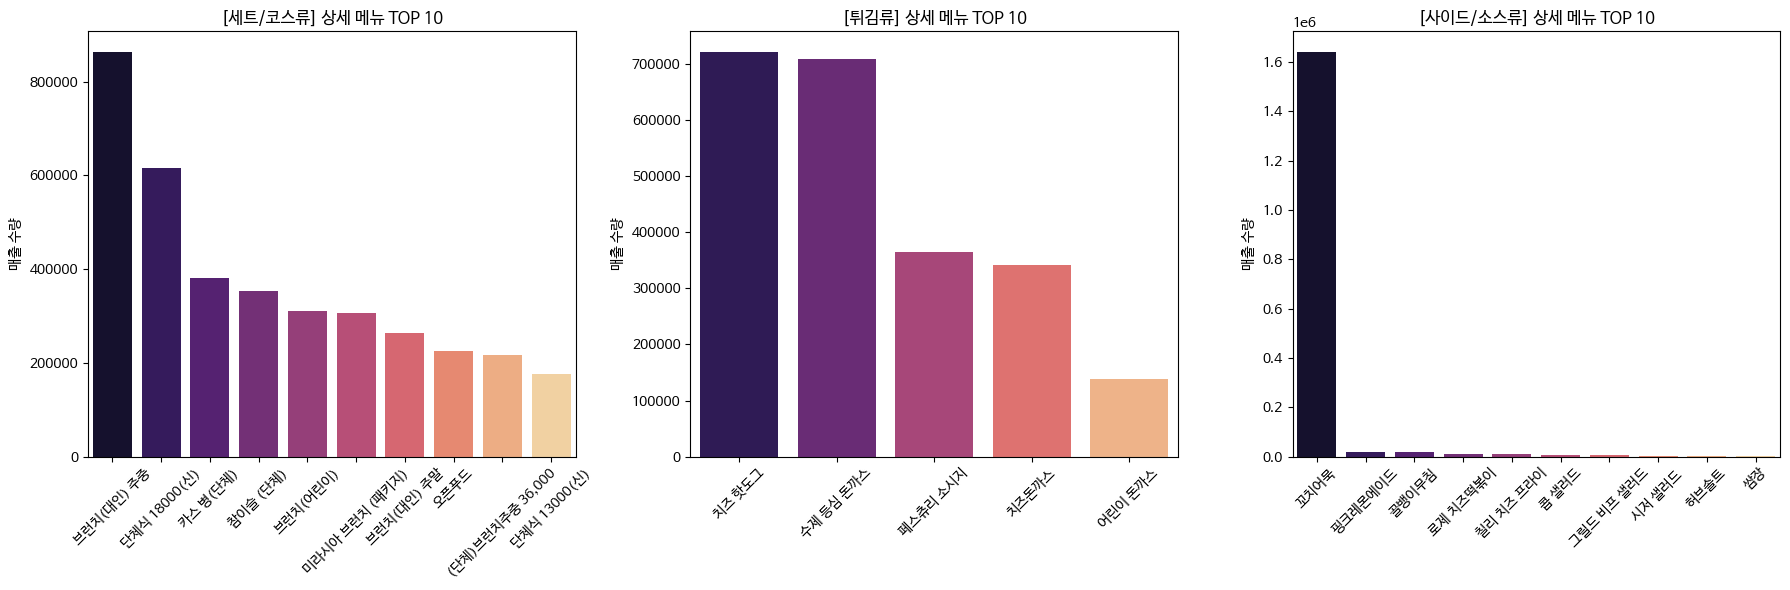

--------------------------------------------------

📊 [세트/코스류] 매출 효자 품목 TOP 5:
   23위: 브런치(대인) 주중 (864,436개)
   16위: 단체식 18000(신) (616,859개)
   29위: 카스 병(단체) (380,975개)
   28위: 참이슬 (단체) (353,268개)
   24위: 브런치(어린이) (311,762개)

📊 [튀김류] 매출 효자 품목 TOP 5:
   33위: 치즈 핫도그 (722,180개)
   31위: 수제 등심 돈까스 (709,512개)
   35위: 페스츄리 소시지 (364,368개)
   34위: 치즈돈까스 (340,944개)
   32위: 어린이 돈까스 (139,225개)

📊 [사이드/소스류] 매출 효자 품목 TOP 5:
   3위: 꼬치어묵 (1,642,944개)
   9위: 핑크레몬에이드 (17,134개)
   1위: 골뱅이무침 (16,838개)
   4위: 로제 치즈떡볶이 (11,890개)
   7위: 칠리 치즈 프라이 (8,612개)


In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 매출 상위 3개 카테고리 이름만 자동으로 뽑아내기
top_3_categories = sales_by_food_subcat.head(3)['최종_Sub'].tolist()
print(f"분석 대상 상위 3개 카테고리: {top_3_categories}\n")

# 2. 상위 3개 카테고리에 해당하는 데이터만 골라내기
top_3_train = food_train[food_train['최종_Sub'].isin(top_3_categories)]

# 3. 각 카테고리 안에서 메뉴별 매출 합계 구하기
# (카테고리별, 메뉴별로 그룹을 지어 합산)
detail_analysis = top_3_train.groupby(['최종_Sub', '메뉴명_clean'])['매출수량'].sum().reset_index()

# 4. 시각화 (3개의 그래프를 한 번에 그리기)
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # 1줄에 3개 그래프 생성

for i, category in enumerate(top_3_categories):
    # 해당 카테고리의 데이터만 추출
    cat_data = detail_analysis[detail_analysis['최종_Sub'] == category]

    # 매출 높은 순서대로 정렬해서 상위 10개만 자르기 (너무 많으면 안 보이니까)
    cat_data = cat_data.sort_values(by='매출수량', ascending=False).head(10)

    # 그래프 그리기
    sns.barplot(data=cat_data, x='메뉴명_clean', y='매출수량', ax=axes[i], palette='magma')

    # 그래프 꾸미기
    axes[i].set_title(f"[{category}] 상세 메뉴 TOP 10")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("매출 수량")
    axes[i].tick_params(axis='x', rotation=45) # 메뉴 이름 겹치지 않게 기울이기

plt.tight_layout()
plt.show()

# 5. 표로도 확인하기 (텍스트 출력)
print("-" * 50)
for category in top_3_categories:
    print(f"\n📊 [{category}] 매출 효자 품목 TOP 5:")
    cat_data = detail_analysis[detail_analysis['최종_Sub'] == category].sort_values(by='매출수량', ascending=False).head(5)

    for idx, row in cat_data.iterrows():
        print(f"   {idx+1}위: {row['메뉴명_clean']} ({row['매출수량']:,}개)")

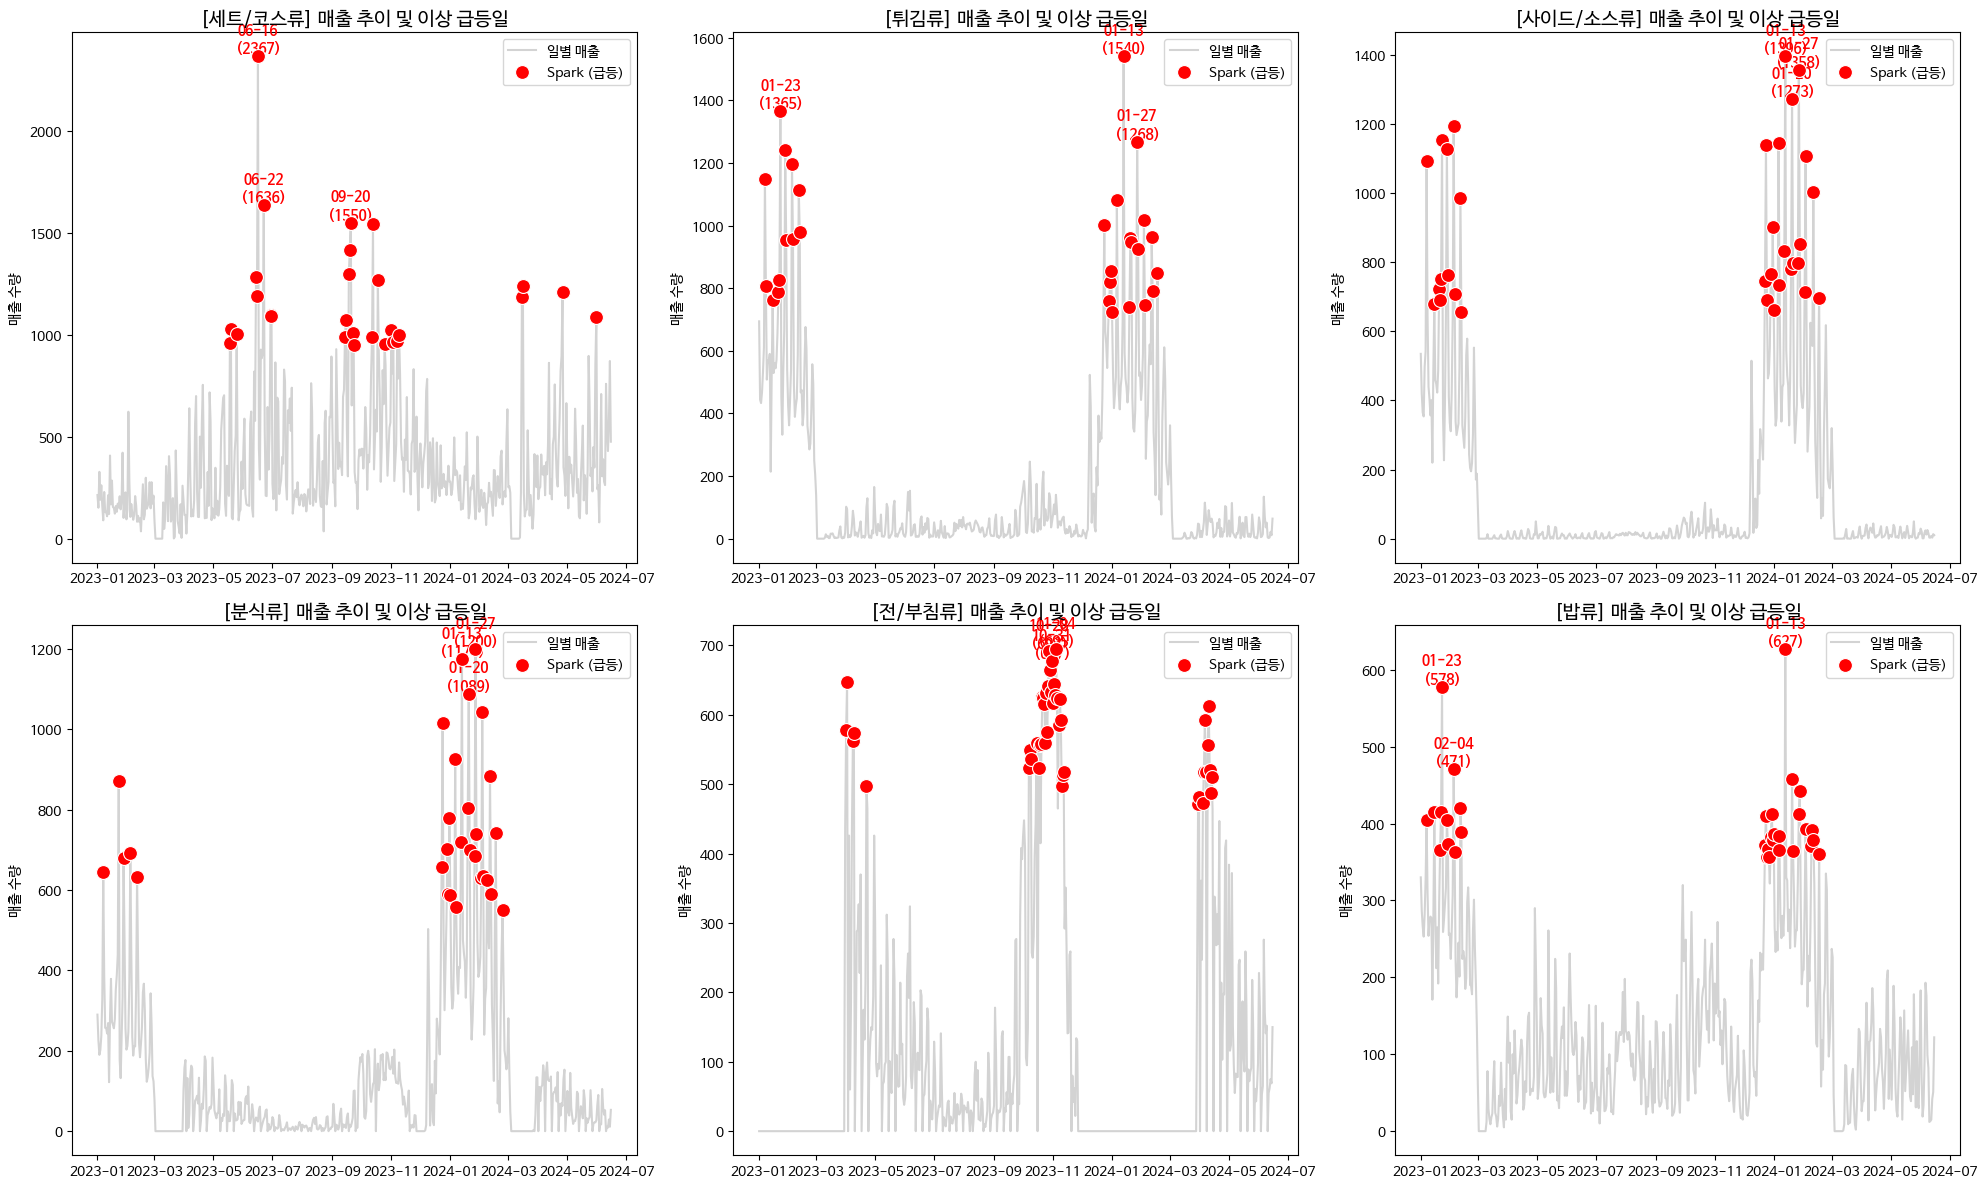

⚡ [음식 카테고리별 주요 매출 폭등일(Spark) 목록]
           영업일자    음식_분류  매출수량          평균
1999 2023-06-16   세트/코스류  2367  362.046992
2071 2023-06-22   세트/코스류  1636  362.046992
3151 2023-09-20   세트/코스류  1550  362.046992
3427 2023-10-13   세트/코스류  1547  362.046992
4534 2024-01-13      튀김류  1540  172.280075
3139 2023-09-19   세트/코스류  1417  362.046992
4530 2024-01-13  사이드/소스류  1396  139.921053
274  2023-01-23      튀김류  1365  172.280075
4698 2024-01-27  사이드/소스류  1358  139.921053
3127 2023-09-18   세트/코스류  1300  362.046992
1975 2023-06-14   세트/코스류  1284  362.046992
4614 2024-01-20  사이드/소스류  1273  139.921053
3487 2023-10-18   세트/코스류  1272  362.046992
4702 2024-01-27      튀김류  1268  172.280075
334  2023-01-28      튀김류  1240  172.280075


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import platform
from matplotlib import font_manager, rc

# ---------------------------------------------------------
# 1. 한글 폰트 설정 (깨짐 방지)
# ---------------------------------------------------------
system_name = platform.system()
if system_name == 'Windows':
    rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':
    rc('font', family='AppleGothic')
else:
    # Colab 등 Linux 환경 (나눔바른고딕 설치 가정)
    rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 2. 데이터 분류 (제공해주신 사전 활용)
# ---------------------------------------------------------
menu_axis_keywords = {
    "음식": {
        "밥류": ["비빔밥","국밥","덮밥","볶음밥","주먹밥","공깃밥","돌솥","밥","햇반"],
        "면류": ["라면","우동","냉면","비빔냉면","파스타","스파게티","짜장","짬뽕",
                "까르보나라","알리오","메밀","면","사리","리조또","투움바","칼국수"],
        "국/탕/찌개류": ["찌개","탕","전골","해장국","갱시기","국","육개장","마라","스튜",
                       "설렁탕","갈비탕","미역국"],
        "구이류": ["구이","스테이크","갈비","삼겹","목살","한우","aus","고기","해산물",
                  "치킨","오븐구이","바비큐","BBQ","양갈비","불고기"],
        "튀김류": ["돈까스","핫도그","소시지","튀김","치킨너겟","까스"],
        "전/부침류": ["파전","전","부침"],
        "찜류": ["찜","찜닭","떡갈비","계란찜","닭발"],
        "볶음류": ["볶음","볶음밥","샹궈"],
        "패스트푸드류": ["피자","햄버거","핫도그","샌드위치"],
        "세트/코스류": ["정식","플래터","platter","모둠","세트","코스","패키지",
                      "단체","브런치","open food","Open Food","오픈푸드"],
        "디저트류": ["아이스크림","붕어빵","와플","케이크","쿠키","빙수","빵","디저트",
                   "현미뻥스크림","뻥스크림","cookie","후식","푸딩"],
        "사이드/소스류": ["쌈장","솔트","치즈","김치","레몬","야채","어묵","꼬치어묵",
                        "파무침","무침","소스","재료","샐러드","추가","토핑"],
        "분식류": ["떡볶이","순대","튀김우동","라볶이"]
    }
}

def classify_food_category(menu_name):
    name = str(menu_name).lower()
    # 예외 처리
    if any(x in name for x in ["소주컵", "종이컵", "테이블", "의자"]):
        return "제외"

    # 음식 카테고리 매칭
    for sub, keywords in menu_axis_keywords["음식"].items():
        if any(k in name for k in keywords):
            return sub
    return "기타"

# 데이터프레임에 분류 적용 (df가 이미 로드되어 있다고 가정)
# df = pd.read_excel("파일경로.xlsx") # 필요 시 주석 해제하여 파일 로드
train['영업일자'] = pd.to_datetime(train['영업일자'])
train['메뉴명_clean'] = train['영업장명_메뉴명'].apply(lambda x: x.split('_')[1] if '_' in x else x)
train['음식_분류'] = train['메뉴명_clean'].apply(classify_food_category)

# 분석 대상: '제외', '기타'가 아닌 음식 데이터만 필터링
target_df = train[~train['음식_분류'].isin(["제외", "기타"])].copy()

# ---------------------------------------------------------
# 3. 스파크(Spark) 탐지 로직 구현
# ---------------------------------------------------------
# 1) 일별, 카테고리별 매출 합계 계산
daily_sales = target_df.groupby(['영업일자', '음식_분류'])['매출수량'].sum().reset_index()

# 2) 카테고리별 통계(평균, 표준편차) 계산
stats = daily_sales.groupby('음식_분류')['매출수량'].agg(['mean', 'std']).reset_index()
stats.columns = ['음식_분류', '평균', '표준편차']

# 3) 데이터 병합 및 이상치 판별
# 조건: 매출수량 > 평균 + (2 * 표준편차)
merged_df = pd.merge(daily_sales, stats, on='음식_분류')
merged_df['is_spark'] = merged_df['매출수량'] > (merged_df['평균'] + (2 * merged_df['표준편차']))

# 스파크 데이터만 추출
sparks = merged_df[merged_df['is_spark'] == True].sort_values(by=['영업일자', '음식_분류'])

# ---------------------------------------------------------
# 4. 시각화 (스파크 지점 표시)
# ---------------------------------------------------------
# 변동성이 큰(표준편차가 큰) 상위 6개 카테고리만 시각화
top_cats = stats.sort_values('표준편차', ascending=False).head(6)['음식_분류'].tolist()

plt.figure(figsize=(20, 12))

for i, cat in enumerate(top_cats):
    plt.subplot(2, 3, i+1)

    # 해당 카테고리 데이터 필터링
    cat_data = merged_df[merged_df['음식_분류'] == cat]
    spark_points = cat_data[cat_data['is_spark'] == True]

    # 전체 매출 흐름 선 그래프
    sns.lineplot(data=cat_data, x='영업일자', y='매출수량', color='lightgray', label='일별 매출')

    # 스파크 지점 빨간 점으로 표시
    sns.scatterplot(data=spark_points, x='영업일자', y='매출수량', color='red', s=100, zorder=10, label='Spark (급등)')

    # 주요 스파크 날짜 텍스트 표시 (상위 3개)
    for _, row in spark_points.sort_values('매출수량', ascending=False).head(3).iterrows():
        plt.text(row['영업일자'], row['매출수량'],
                 f"{row['영업일자'].strftime('%m-%d')}\n({int(row['매출수량'])})",
                 color='red', fontweight='bold', ha='center', va='bottom')

    plt.title(f"[{cat}] 매출 추이 및 이상 급등일", fontsize=14)
    plt.xlabel("")
    plt.ylabel("매출 수량")
    plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 5. 결과 리포트 출력
# ---------------------------------------------------------
print("⚡ [음식 카테고리별 주요 매출 폭등일(Spark) 목록]")
print(sparks[['영업일자', '음식_분류', '매출수량', '평균']].sort_values(by='매출수량', ascending=False).head(15))

단체 손님이 역시 매출엔 최고구나!

📊 [유형별 매출 상위 메뉴 데이터]
    Day_Type     메뉴명_clean   매출수량
45       공휴일          꼬치어묵   7840
59       공휴일           떡볶이   6238
168      공휴일          해물파전   4264
85       공휴일    브런치(대인) 주말   3922
93       공휴일            생수   3766
221       주말          꼬치어묵  37055
344       주말          해물파전  33852
235       주말           떡볶이  30192
269       주말            생수  22799
284       주말    아메리카노(ICE)  18495
397       평일          꼬치어묵  23841
520       평일          해물파전  22010
411       평일           떡볶이  19997
400       평일  단체식 18000(신)  19653
438       평일    브런치(대인) 주중  15411


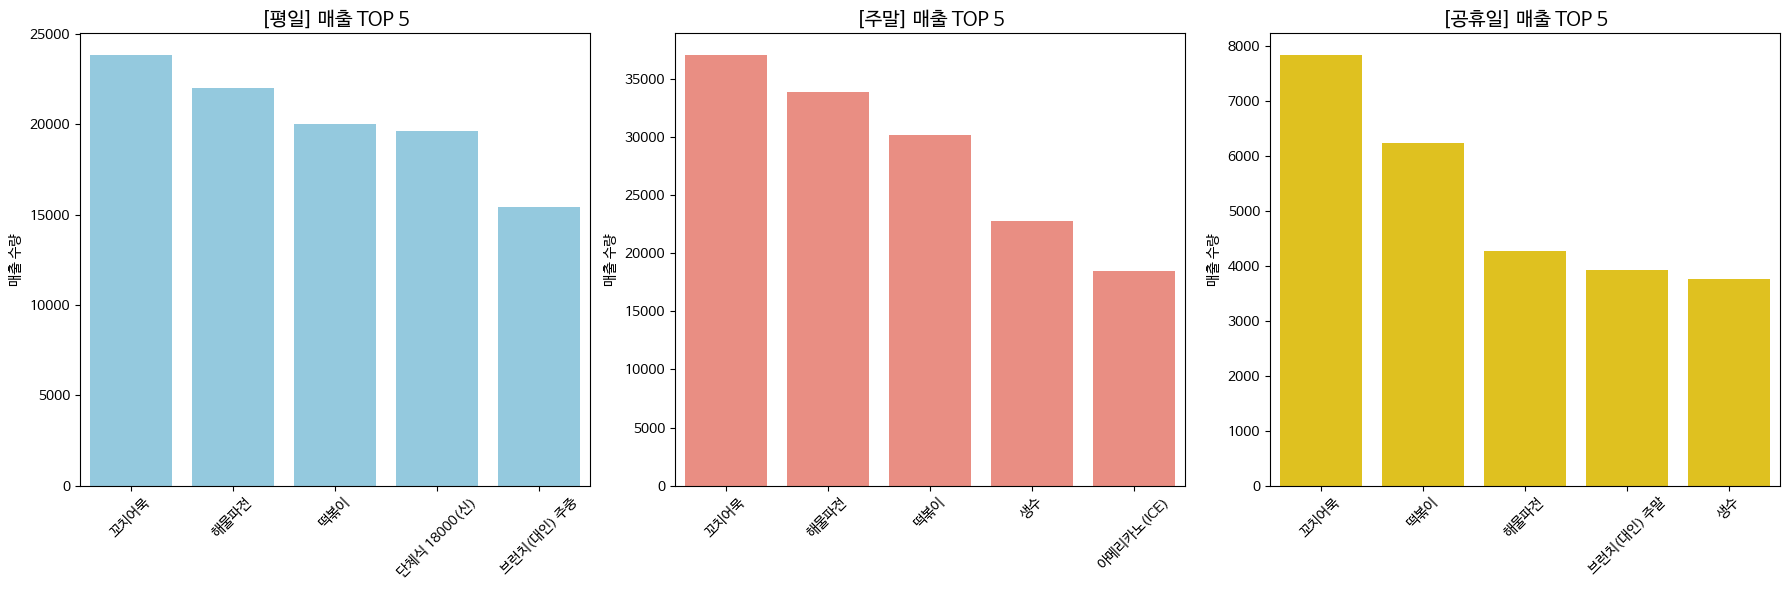

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Day_Type 생성 (이미 만든 '전체공휴일여부' & '주말여부' 활용)
# ---------------------------------------------------------
# 우선순위: 공휴일 > 주말 > 평일
def get_day_type_refined(row):
    if row['전체공휴일여부'] == 1:
        return "공휴일"
    elif row['주말여부'] == "주말":
        return "주말"
    else:
        return "평일"

# 기존 train 데이터프레임에 적용
train['Day_Type'] = train.apply(get_day_type_refined, axis=1)

# ---------------------------------------------------------
# 2. 메뉴명 정제 및 데이터 필터링
# ---------------------------------------------------------
# 메뉴명 정제 (가게이름 제거)
train['메뉴명_clean'] = train['영업장명_메뉴명'].apply(lambda x: x.split('_')[1] if '_' in x else x)

# [중요] 이전 단계에서 수행하신 '음식' 카테고리 필터링이 필요하다면 아래를 활성화하세요.
# target_df = train[train['최종_Top'] == '음식'].copy()
# target_df가 없다면 우선 전체 train을 사용합니다.
target_df = train.copy()

# ---------------------------------------------------------
# 3. 유형별 매출 집계 및 TOP 5 추출
# ---------------------------------------------------------
# 요일유형 & 메뉴별 합계 구하기
grouped = target_df.groupby(['Day_Type', '메뉴명_clean'])['매출수량'].sum().reset_index()

# 각 유형별(평일,주말,공휴일)로 매출 높은 순 정렬 후 상위 5개 뽑기
top_menus = grouped.sort_values(['Day_Type', '매출수량'], ascending=[True, False])
top_menus = top_menus.groupby('Day_Type').head(5)

print("📊 [유형별 매출 상위 메뉴 데이터]")
print(top_menus)

# ---------------------------------------------------------
# 4. 시각화 (3개 그래프 나란히 그리기)
# ---------------------------------------------------------
plt.figure(figsize=(18, 6))
day_types = ["평일", "주말", "공휴일"]
colors = ['skyblue', 'salmon', 'gold']

for i, dtype in enumerate(day_types):
    plt.subplot(1, 3, i+1)

    # 해당 유형 데이터만 필터링
    data = top_menus[top_menus['Day_Type'] == dtype]

    if data.empty:
        plt.title(f"{dtype} (데이터 없음)")
        continue

    sns.barplot(data=data, x='메뉴명_clean', y='매출수량', color=colors[i])

    plt.title(f"[{dtype}] 매출 TOP 5", fontsize=14)
    plt.xlabel("")
    plt.ylabel("매출 수량")
    plt.xticks(rotation=45)

    # y축 지수 표기(1e6) 방지
    plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

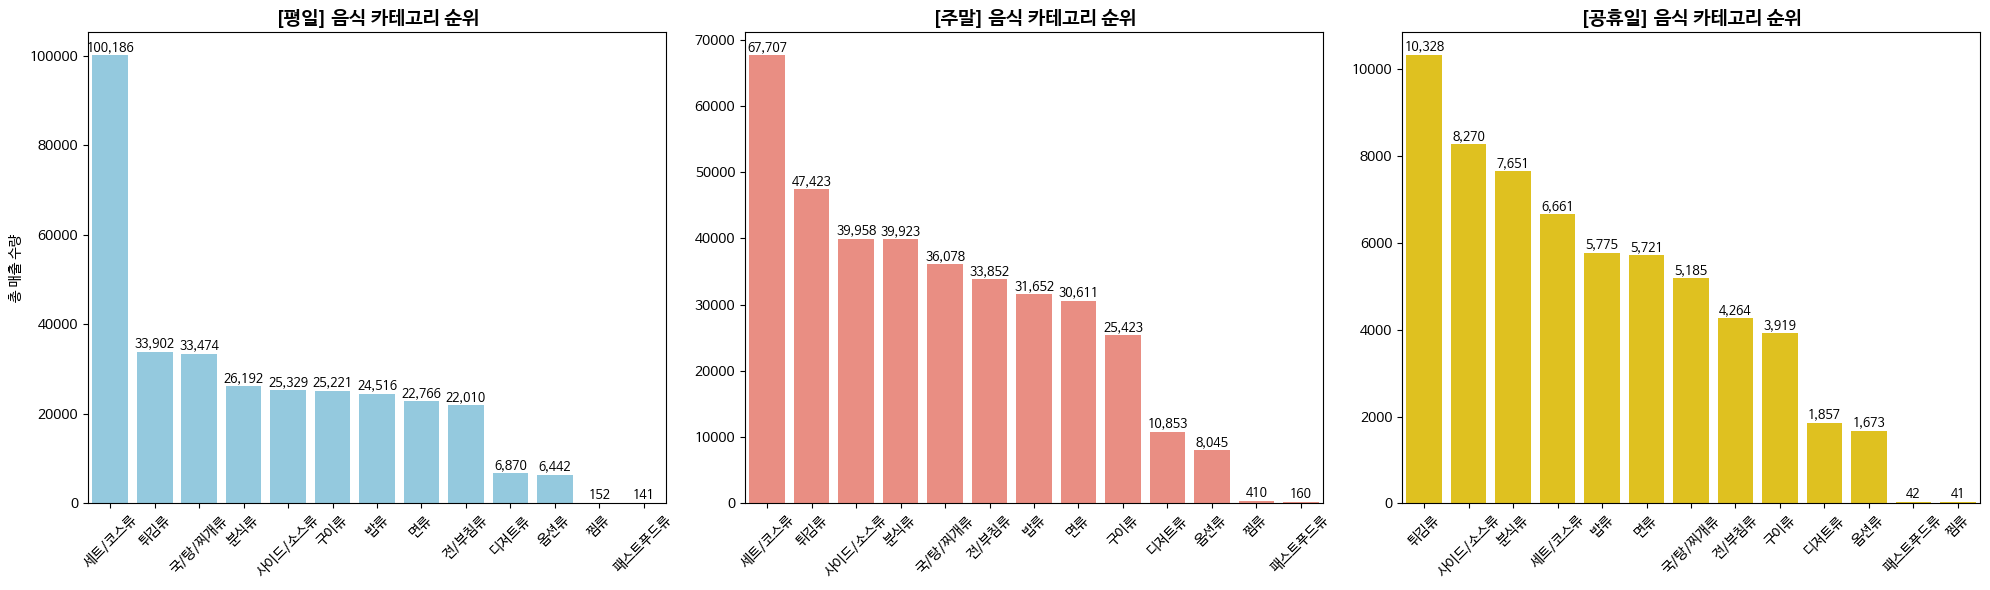


📊 [음식 카테고리별 매출 수량 비교표]
Day_Type      평일     주말    공휴일
최종_Sub                        
세트/코스류    100186  67707   6661
튀김류        33902  47423  10328
국/탕/찌개류    33474  36078   5185
분식류        26192  39923   7651
사이드/소스류    25329  39958   8270
밥류         24516  31652   5775
전/부침류      22010  33852   4264
면류         22766  30611   5721
구이류        25221  25423   3919
디저트류        6870  10853   1857
옵션류         6442   8045   1673
찜류           152    410     41
패스트푸드류       141    160     42


In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Day_Type 생성 (이미 만든 '전체공휴일여부' & '주말여부' 활용)
# ---------------------------------------------------------
def get_day_type_refined(row):
    # 1순위: 공휴일 (전체공휴일여부 == 1)
    if row['전체공휴일여부'] == 1:
        return "공휴일"
    # 2순위: 주말 (질문자님이 설정하신 금/토/일 기준)
    elif row['주말여부'] == "주말":
        return "주말"
    else:
        return "평일"

# 기존 train 데이터프레임에 적용
train['Day_Type'] = train.apply(get_day_type_refined, axis=1)

# ---------------------------------------------------------
# 2. 데이터 집계 (음식 카테고리 Grouping)
# ---------------------------------------------------------
# (1) '음식' 대분류만 선택 (제외/기타는 이미 음식_분류에서 걸러짐)
# 앞서 만드신 음식_분류 컬럼을 활용해 분석 대상을 필터링합니다.
target_food_df = train[~train['음식_분류'].isin(["제외", "기타"])].copy()

# (2) [요일유형] 및 [음식 소분류(최종_Sub)] 기준으로 매출 합산
# '매출수량' 컬럼명을 직접 사용합니다.
category_sales = target_food_df.groupby(['Day_Type', '최종_Sub'])['매출수량'].sum().reset_index()

# ---------------------------------------------------------
# 3. 시각화 (3개 그래프 병렬 배치)
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
day_types = ["평일", "주말", "공휴일"]
colors = ['skyblue', 'salmon', 'gold']

for i, dtype in enumerate(day_types):
    # 해당 요일 유형 데이터만 추출
    data = category_sales[category_sales['Day_Type'] == dtype]

    if data.empty:
        axes[i].set_title(f"{dtype} (데이터 없음)")
        continue

    # 매출 높은 순서대로 정렬
    data = data.sort_values(by='매출수량', ascending=False)

    # 막대 그래프 그리기
    sns.barplot(data=data, x='최종_Sub', y='매출수량', ax=axes[i], color=colors[i])

    # 그래프 꾸미기
    axes[i].set_title(f"[{dtype}] 음식 카테고리 순위", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("총 매출 수량" if i == 0 else "")
    axes[i].tick_params(axis='x', rotation=45)

    # 막대 위에 숫자 표시 (가독성 향상)
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].text(p.get_x() + p.get_width() / 2., height + 3,
                     f'{int(height):,}', ha='center', va='bottom', fontsize=9)

    # y축 지수 표기(1e6) 방지 (일반 숫자로 표시)
    axes[i].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. 수치 비교표 출력
# ---------------------------------------------------------
pivot_table = category_sales.pivot(index='최종_Sub', columns='Day_Type', values='매출수량').fillna(0)

# 가독성을 위해 컬럼 순서 고정 및 합계 기준 정렬
available_cols = [c for c in day_types if c in pivot_table.columns]
pivot_table = pivot_table[available_cols]
pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values('Total', ascending=False)

print("\n📊 [음식 카테고리별 매출 수량 비교표]")
print(pivot_table.drop(columns='Total'))

/tmp/ipython-input-3574395714.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_fried, x='매출수량', y='메뉴명_clean', palette='Oranges_r')


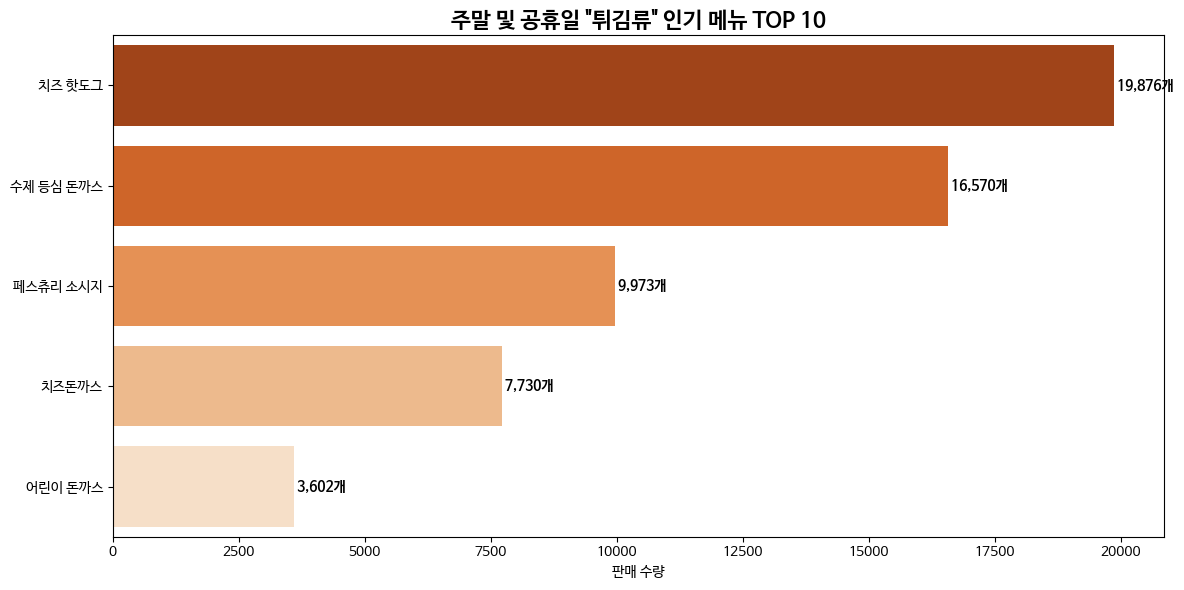

🍤 [주말/공휴일 튀김류 매출 상세 순위]
3위: 치즈 핫도그 (19,876개)
1위: 수제 등심 돈까스 (16,570개)
5위: 페스츄리 소시지 (9,973개)
4위: 치즈돈까스 (7,730개)
2위: 어린이 돈까스 (3,602개)


In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc

# ---------------------------------------------------------
# 1. 한글 폰트 설정
# ---------------------------------------------------------
system_name = platform.system()
if system_name == 'Windows':
    rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 2. 데이터 필터링 (핵심!)
# ---------------------------------------------------------
# (1) 주말과 공휴일 데이터만 선택 ('평일' 제외)
weekend_holiday_df = train[train['Day_Type'].isin(['주말', '공휴일'])].copy()

# (2) 그 중에서 '튀김류' 카테고리만 선택
fried_food_df = weekend_holiday_df[weekend_holiday_df['최종_Sub'] == '튀김류']

# ---------------------------------------------------------
# 3. 메뉴별 매출 집계 및 정렬
# ---------------------------------------------------------
# 메뉴명으로 묶어서 매출 합계 계산
fried_ranking = fried_food_df.groupby('메뉴명_clean')['매출수량'].sum().reset_index()

# 매출 높은 순으로 정렬
fried_ranking = fried_ranking.sort_values(by='매출수량', ascending=False)

# 상위 10개만 추출
top_10_fried = fried_ranking.head(10)

# ---------------------------------------------------------
# 4. 시각화 (집중 분석 그래프)
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# 막대 그래프 그리기 (가독성을 위해 가로 막대 추천)
sns.barplot(data=top_10_fried, x='매출수량', y='메뉴명_clean', palette='Oranges_r')

plt.title('주말 및 공휴일 "튀김류" 인기 메뉴 TOP 10', fontsize=16, fontweight='bold')
plt.xlabel('판매 수량')
plt.ylabel('') # 메뉴명은 왼쪽에 있으므로 라벨 생략

# 막대 옆에 수치 표시
for i, v in enumerate(top_10_fried['매출수량']):
    plt.text(v, i, f' {v:,}개', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 5. 텍스트 리포트
# ---------------------------------------------------------
print("🍤 [주말/공휴일 튀김류 매출 상세 순위]")
if fried_ranking.empty:
    print("해당 기간에 판매된 튀김류 데이터가 없습니다.")
else:
    for idx, row in fried_ranking.head(10).iterrows():
        print(f"{idx+1}위: {row['메뉴명_clean']} ({row['매출수량']:,}개)")

# *Season 변수 추가*

/tmp/ipython-input-268645567.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_menus_season = top_menus_season.groupby('Season').head(10)
/tmp/ipython-input-268645567.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='매출수량', y='메뉴명_clean', ax=axes[i], palette=season_colors[season])
/tmp/ipython-input-268645567.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='매출수량', y='메뉴명_clean', ax=axes[i], palette=season_colors[season])
/tmp/ipython-input-268645567.py:80: Fut

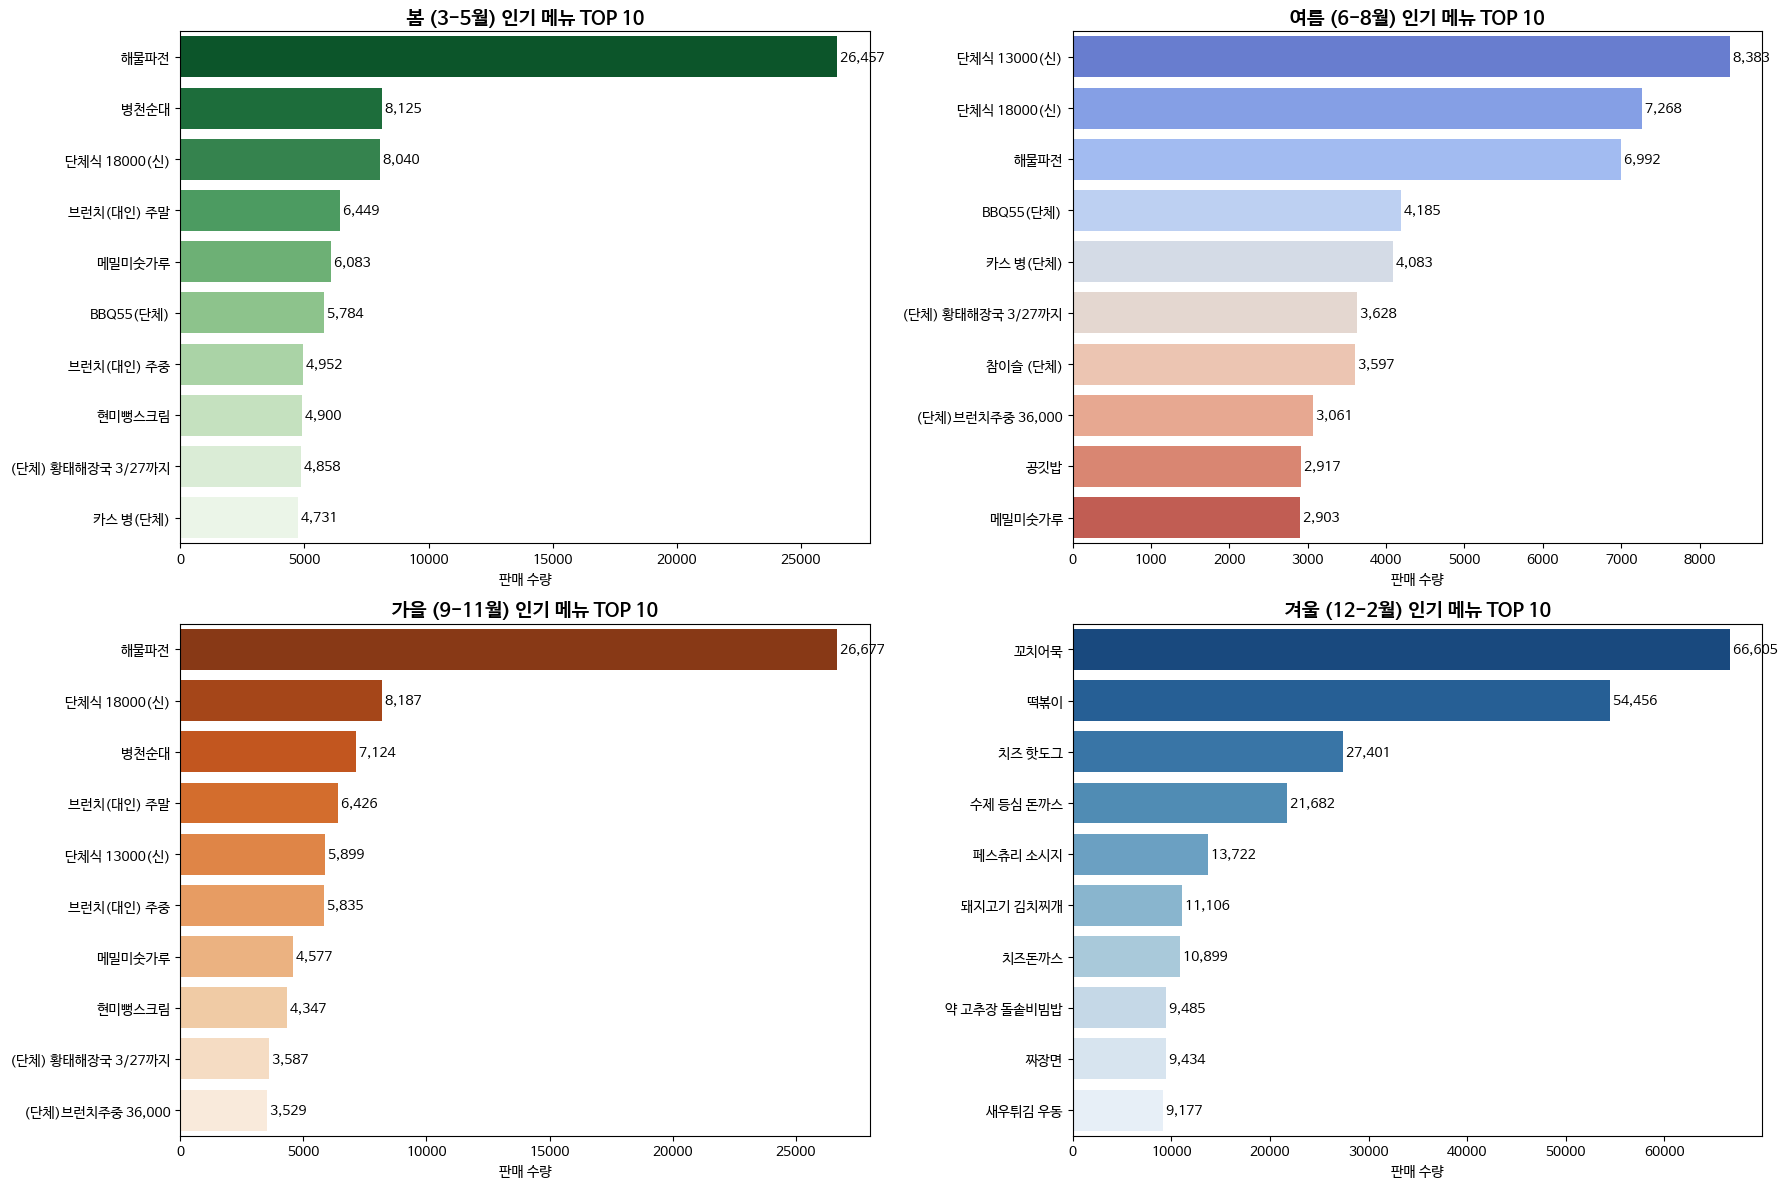

--------------------------------------------------

📅 [봄 (3-5월)] 매출 효자 메뉴 TOP 5:
   - 해물파전: 26,457개
   - 병천순대: 8,125개
   - 단체식 18000(신): 8,040개
   - 브런치(대인) 주말: 6,449개
   - 메밀미숫가루: 6,083개

📅 [여름 (6-8월)] 매출 효자 메뉴 TOP 5:
   - 단체식 13000(신): 8,383개
   - 단체식 18000(신): 7,268개
   - 해물파전: 6,992개
   - BBQ55(단체): 4,185개
   - 카스 병(단체): 4,083개

📅 [가을 (9-11월)] 매출 효자 메뉴 TOP 5:
   - 해물파전: 26,677개
   - 단체식 18000(신): 8,187개
   - 병천순대: 7,124개
   - 브런치(대인) 주말: 6,426개
   - 단체식 13000(신): 5,899개

📅 [겨울 (12-2월)] 매출 효자 메뉴 TOP 5:
   - 꼬치어묵: 66,605개
   - 떡볶이: 54,456개
   - 치즈 핫도그: 27,401개
   - 수제 등심 돈까스: 21,682개
   - 페스츄리 소시지: 13,722개


In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc

# ---------------------------------------------------------
# 1. 한글 폰트 설정
# ---------------------------------------------------------
system_name = platform.system()
if system_name == 'Windows':
    rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 2. 계절 구분 함수 정의
# ---------------------------------------------------------
def get_season(월):
    if 월 in [3, 4, 5]:
        return "봄 (3-5월)"
    elif 월 in [6, 7, 8]:
        return "여름 (6-8월)"
    elif 월 in [9, 10, 11]:
        return "가을 (9-11월)"
    else:
        return "겨울 (12-2월)"

# ---------------------------------------------------------
# 3. 데이터 전처리
# ---------------------------------------------------------
# 날짜 형식 변환 및 계절 컬럼 생성
train['영업일자'] = pd.to_datetime(train['영업일자'])
train['월'] = train['영업일자'].dt.month
train['Season'] = train['월'].apply(get_season)

# '음식' 카테고리만 필터링
food_df = train[train['최종_Top'] == '음식'].copy()

# ---------------------------------------------------------
# 4. 계절별 인기 메뉴 집계 (TOP 10)
# ---------------------------------------------------------
# 계절 & 메뉴명으로 그룹핑하여 매출 합계 계산
season_rank = food_df.groupby(['Season', '메뉴명_clean'])['매출수량'].sum().reset_index()

# 계절 순서 정의 (시각화 순서 정렬용)
season_order = ["봄 (3-5월)", "여름 (6-8월)", "가을 (9-11월)", "겨울 (12-2월)"]
season_rank['Season'] = pd.Categorical(season_rank['Season'], categories=season_order, ordered=True)

# 각 계절별 매출 TOP 10 뽑기
top_menus_season = season_rank.sort_values(['Season', '매출수량'], ascending=[True, False])
top_menus_season = top_menus_season.groupby('Season').head(10)

# ---------------------------------------------------------
# 5. 시각화 (4분할 그래프)
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 12)) # 2행 2열
axes = axes.flatten() # for문 돌리기 편하게 1차원으로 펼침

# 계절별 테마 색상 (봄:초록/분홍, 여름:파랑/빨강, 가을:갈색/주황, 겨울:회색/하늘)
season_colors = {
    "봄 (3-5월)": "Greens_r",
    "여름 (6-8월)": "coolwarm", # 시원함+더움
    "가을 (9-11월)": "Oranges_r",
    "겨울 (12-2월)": "Blues_r"
}

for i, season in enumerate(season_order):
    # 해당 계절 데이터 추출
    data = top_menus_season[top_menus_season['Season'] == season]

    if data.empty:
        axes[i].set_title(f"{season} (데이터 없음)")
        continue

    # 가로 막대 그래프
    sns.barplot(data=data, x='매출수량', y='메뉴명_clean', ax=axes[i], palette=season_colors[season])

    # 그래프 꾸미기
    axes[i].set_title(f"🌸☀️ {season} 인기 메뉴 TOP 10 🍁❄️", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("판매 수량")
    axes[i].set_ylabel("")

    # 수치 표시
    for index, value in enumerate(data['매출수량']):
        axes[i].text(value, index, f' {value:,}', va='center')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. 텍스트 리포트
# ---------------------------------------------------------
print("-" * 50)
for season in season_order:
    print(f"\n📅 [{season}] 매출 효자 메뉴 TOP 5:")
    subset = top_menus_season[top_menus_season['Season'] == season].head(5)
    for idx, row in subset.iterrows():
        print(f"   - {row['메뉴명_clean']}: {row['매출수량']:,}개")

/tmp/ipython-input-192954793.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='최종_Sub', y='매출수량', ax=axes[i], palette=season_colors[season])
/tmp/ipython-input-192954793.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='최종_Sub', y='매출수량', ax=axes[i], palette=season_colors[season])
/tmp/ipython-input-192954793.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='최종_Sub', y='매출수량', ax=axes[i], palette=season_colors[season])
/tmp/ipython-input-192954793.py:76: FutureWarning: 

Passing `palette` wi

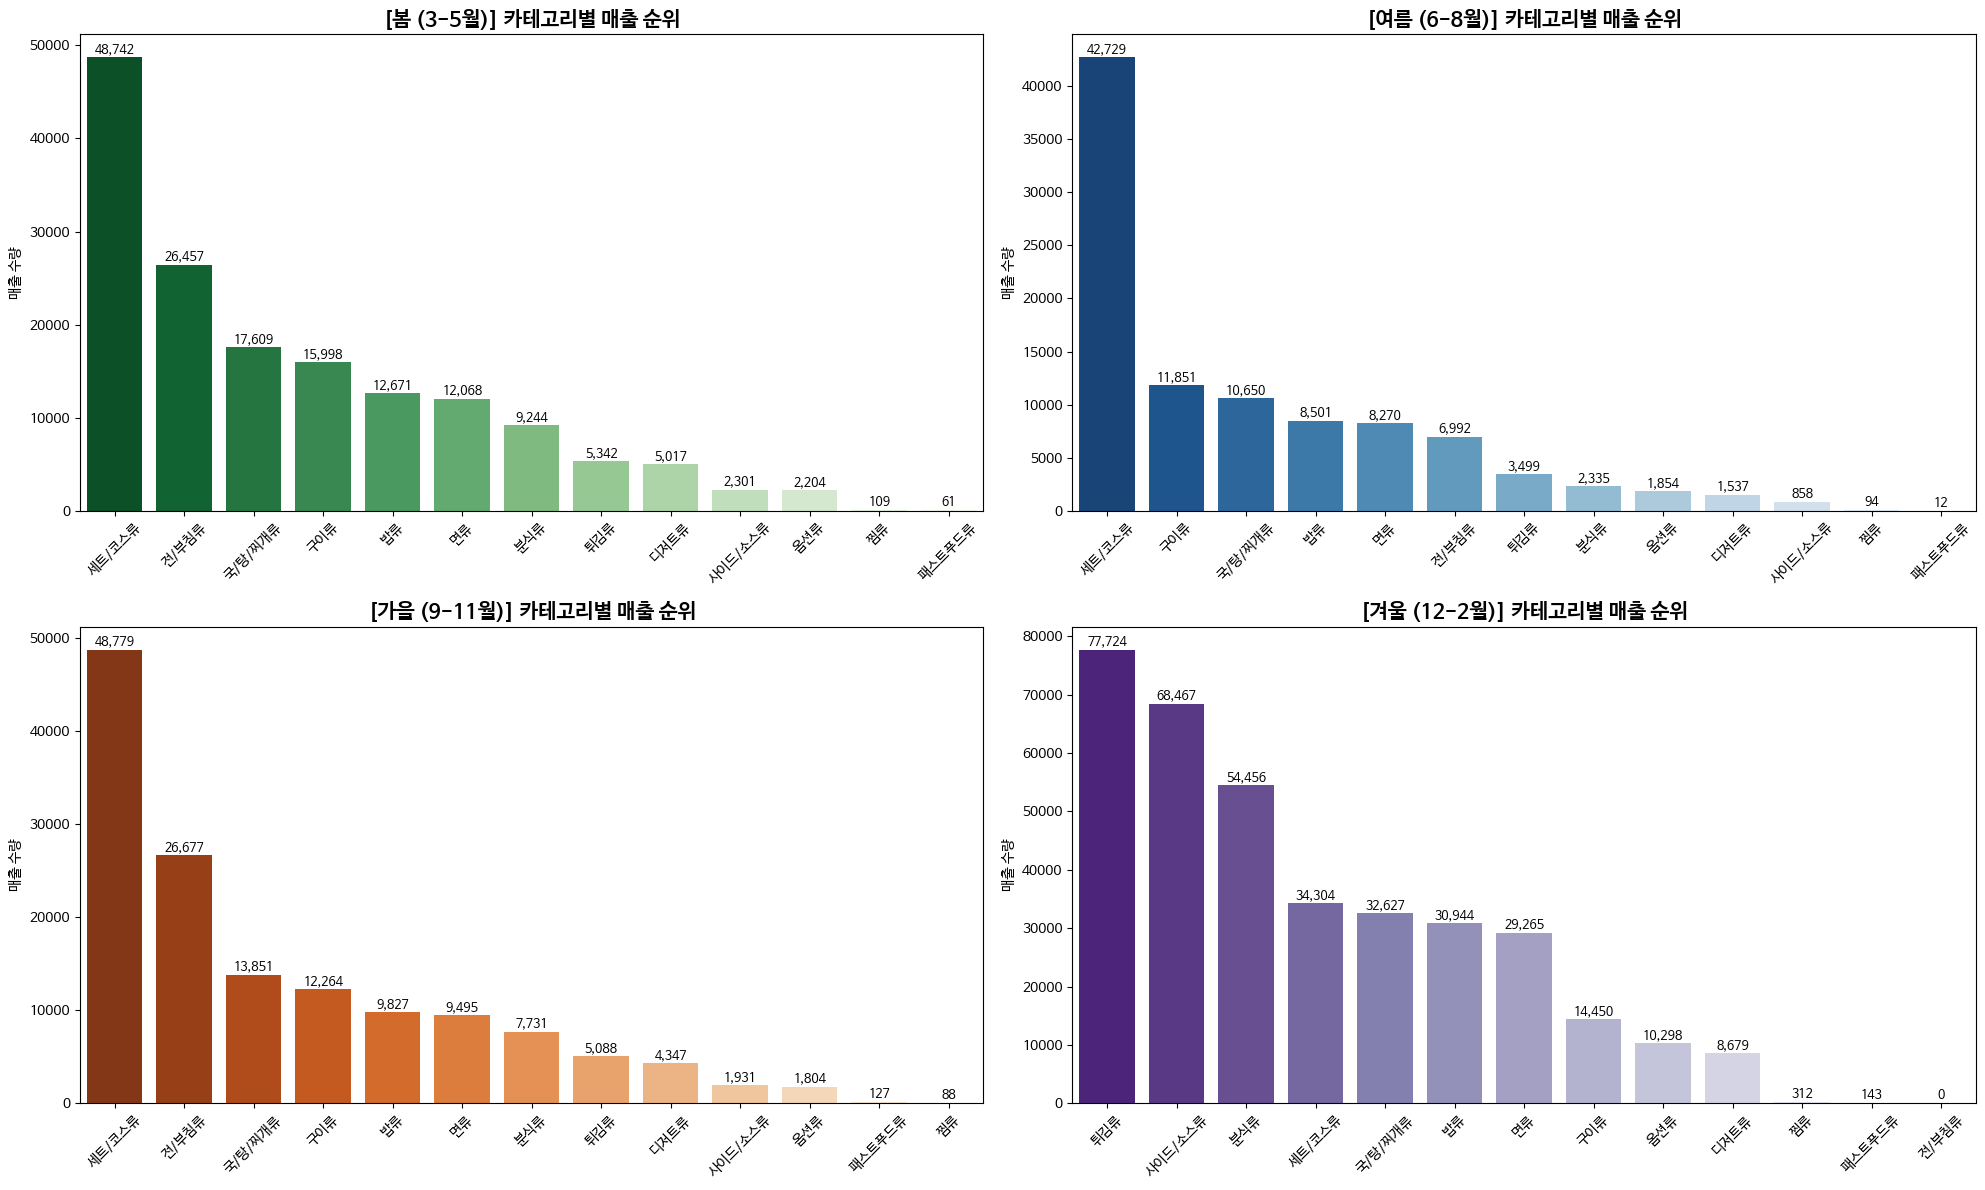


📊 [계절별 음식 카테고리 매출 수량표]
Season   봄 (3-5월)  여름 (6-8월)  가을 (9-11월)  겨울 (12-2월)
최종_Sub                                              
구이류         15998      11851       12264       14450
국/탕/찌개류     17609      10650       13851       32627
디저트류         5017       1537        4347        8679
면류          12068       8270        9495       29265
밥류          12671       8501        9827       30944
분식류          9244       2335        7731       54456
사이드/소스류      2301        858        1931       68467
세트/코스류      48742      42729       48779       34304
옵션류          2204       1854        1804       10298
전/부침류       26457       6992       26677           0
찜류            109         94          88         312
튀김류          5342       3499        5088       77724
패스트푸드류         61         12         127         143


In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc

# ---------------------------------------------------------
# 1. 한글 폰트 설정
# ---------------------------------------------------------
system_name = platform.system()
if system_name == 'Windows':
    rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 2. 계절 구분 함수
# ---------------------------------------------------------
def get_season(월):
    if 월 in [3, 4, 5]:
        return "봄 (3-5월)"
    elif 월 in [6, 7, 8]:
        return "여름 (6-8월)"
    elif 월 in [9, 10, 11]:
        return "가을 (9-11월)"
    else:
        return "겨울 (12-2월)"

# ---------------------------------------------------------
# 3. 데이터 전처리 (계절 컬럼 생성)
# ---------------------------------------------------------
train['Season'] = train['월'].apply(get_season)

# '음식' 카테고리만 필터링 (이미 분류된 '최종_Top' 컬럼 사용 가정)
# 만약 '최종_Sub' 컬럼이 없다면 이전 단계의 분류 로직을 먼저 실행해야 합니다.
food_df = train[train['최종_Top'] == '음식'].copy()

# ---------------------------------------------------------
# 4. 계절별 & 카테고리별 집계 (핵심 변경 사항)
# ---------------------------------------------------------
# 메뉴명(메뉴명_clean) 대신 -> 소분류(최종_Sub)로 그룹핑
season_cat_rank = food_df.groupby(['Season', '최종_Sub'])['매출수량'].sum().reset_index()

# 계절 순서 지정
season_order = ["봄 (3-5월)", "여름 (6-8월)", "가을 (9-11월)", "겨울 (12-2월)"]

# ---------------------------------------------------------
# 5. 시각화 (4분할 그래프)
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

# 계절별 색상 테마
season_colors = {
    "봄 (3-5월)": "Greens_r",   # 초록 계열
    "여름 (6-8월)": "Blues_r",  # 파란 계열 (시원함)
    "가을 (9-11월)": "Oranges_r", # 주황/단풍 계열
    "겨울 (12-2월)": "Purples_r"  # 보라/회색 계열
}

for i, season in enumerate(season_order):
    # 해당 계절 데이터 추출
    data = season_cat_rank[season_cat_rank['Season'] == season]

    if data.empty:
        axes[i].set_title(f"{season} (데이터 없음)")
        continue

    # 매출 높은 순 정렬
    data = data.sort_values(by='매출수량', ascending=False)

    # 막대 그래프 그리기
    sns.barplot(data=data, x='최종_Sub', y='매출수량', ax=axes[i], palette=season_colors[season])

    # 그래프 꾸미기
    axes[i].set_title(f"[{season}] 카테고리별 매출 순위", fontsize=15, fontweight='bold')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("매출 수량")
    axes[i].tick_params(axis='x', rotation=45) # X축 글자 기울이기

    # 막대 위에 숫자 표시
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].text(p.get_x() + p.get_width() / 2., height + 10,
                     f'{int(height):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. 표로 요약 확인 (피벗 테이블)
# ---------------------------------------------------------
pivot_season = season_cat_rank.pivot(index='최종_Sub', columns='Season', values='매출수량').fillna(0)
# 계절 순서대로 컬럼 정렬
pivot_season = pivot_season[season_order]

print("\n📊 [계절별 음식 카테고리 매출 수량표]")
print(pivot_season)

# 평일엔 단체 급식/행사 위주, 주말엔 가족 나들이/매점 위주
1. 튀김류 분석: "들고 다니는 간식" vs "가족 식사"
- 1위 치즈 핫도그 (15,859개) & 3위 페스츄리 소시지 (8,131개) : 주말 고객의 상당수는 자리에 오래 앉아있기보다, 빠르게 허기를 채우고 이동하거나 놀고 싶어.
- 2위 수제 등심 돈까스 (13,353개) & 4위 치즈돈까스, 5위 어린이 돈까스 : 아이를 동반한 가족의 실패 없는 식사 메뉴
2. 요일별 매출 패턴
- 평일 : 세트/코스류가 압도적 1위 : 기업 연수, 단체 관광, 혹은 구내식당 형태의 단체 손님이 매출의 핵심.
- 주말/ 공휴일 : 단체식 메뉴의 매출은 급감. 개별 관광객, 가족 단위 나들이객으로 고객층이 완전히 물갈이, TOP 5 순위에 브런치(대인) 메뉴가 등장(튀김/분식 같은 간편식 외에도, 주말 오전에 여유롭게 식사를 즐기려는 수요층(아마도 커플이나 젊은 부부)이 존재함)
3. 꼬치어묵!!:평일, 주말, 공휴일 가리지 않고 꼬치어묵이 매출 수량 1위
4. 계절별
- 겨울(12-2월): 압도적 성수기이자 분식이 판을 친다. : 꼬치어묵(6.6만), 떡볶이(5.4만), 핫도그(2.7만) 등 따뜻하고 빠르게 먹는 길거리 간식이 매출을 지배.
- 봄/가을: 해물파전의 독주. 병천순대와 메밀미숫가루가 상위권인 것으로 보아, 등산이나 트레킹 후 막걸리 한 잔 곁들이는 중장년층/나들이객이 주 고객.
- 여름(6-8월): 개인 손님은 줄고, 단체가 먹여 살린다. 하계 워크숍, 야유회, 물놀이 단체 등 사전에 예약된 단체 손님 위주.

⚡ [매출 스파크 발생 TOP 10] - 이날 무슨 일이 있었나요?
            영업일자 메뉴명_clean  매출수량          평균
66397 2024-01-13      꼬치어묵  1372  129.203008
68861 2024-01-27      꼬치어묵  1329  129.203008
67629 2024-01-20      꼬치어묵  1235  129.203008
68875 2024-01-27       떡볶이  1200  106.065789
66411 2024-01-13       떡볶이  1174  106.065789
6029  2023-02-04      꼬치어묵  1165  129.203008
3917  2023-01-23      꼬치어묵  1130  129.203008
65165 2024-01-06      꼬치어묵  1114  129.203008
4797  2023-01-28      꼬치어묵  1107  129.203008
62877 2023-12-24      꼬치어묵  1094  129.203008


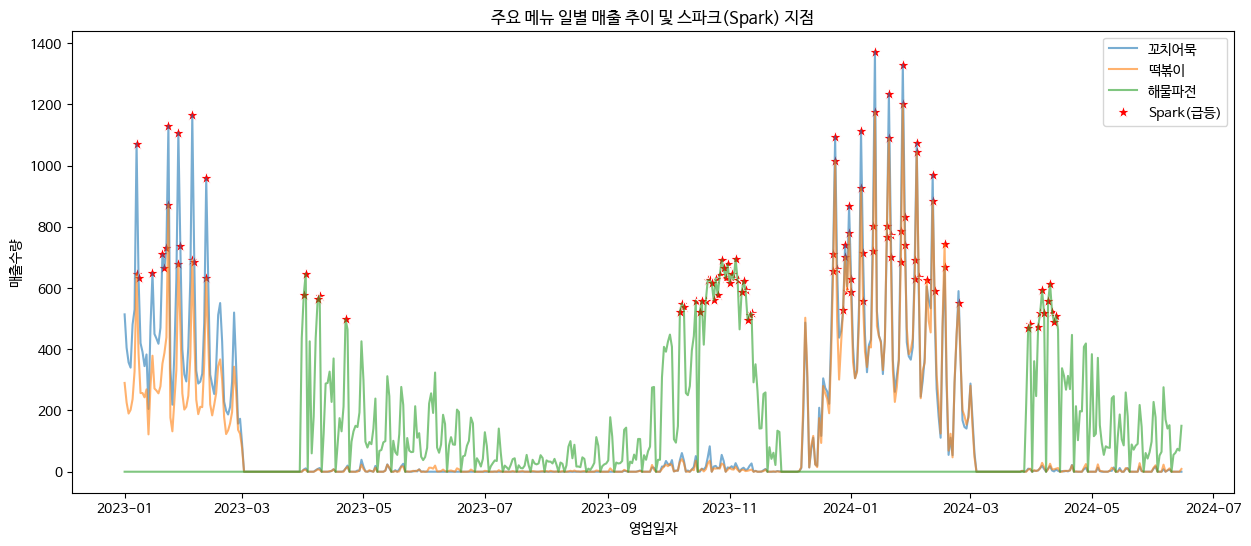

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 스파크(이상치) 탐지 로직 준비
# ---------------------------------------------------------
# 메뉴별로 '평균 매출'과 '표준편차'를 구합니다.
# (어떤 메뉴는 평소에 10개 팔리다가 100개 팔리면 대박이지만,
#  평소에 1000개 팔리던 게 1100개 팔린 건 스파크가 아니니까요.)

# 일별/메뉴별 매출 집계
daily_menu_sales = train.groupby(['영업일자', '메뉴명_clean'])['매출수량'].sum().reset_index()

# 메뉴별 통계 계산 (평균, 표준편차)
menu_stats = daily_menu_sales.groupby('메뉴명_clean')['매출수량'].agg(['mean', 'std']).reset_index()
menu_stats.columns = ['메뉴명_clean', '평균', '표준편차']

# 데이터 합치기
spark_train = pd.merge(daily_menu_sales, menu_stats, on='메뉴명_clean')

# ---------------------------------------------------------
# 2. '스파크' 정의 (Z-Score 방식 활용)
# ---------------------------------------------------------
# 조건: 매출수량이 (평균 + 2 * 표준편차)보다 큰 경우
# 즉, 평소보다 비정상적으로 많이 팔린 날만 골라냅니다.
spark_train['is_spark'] = spark_train['매출수량'] > (spark_train['평균'] + (2 * spark_train['표준편차']))

# 스파크인 데이터만 필터링하고, 매출 수량이 높은 순서대로 정렬
sparks = spark_train[spark_train['is_spark'] == True].sort_values(by='매출수량', ascending=False)

# ---------------------------------------------------------
# 3. 결과 출력 (상위 10개 스파크)
# ---------------------------------------------------------
print("⚡ [매출 스파크 발생 TOP 10] - 이날 무슨 일이 있었나요?")
print(sparks[['영업일자', '메뉴명_clean', '매출수량', '평균']].head(10))

# ---------------------------------------------------------
# 4. 시각화: 시계열 그래프로 스파크 찍어보기 (전체 추세)
# ---------------------------------------------------------
plt.figure(figsize=(15, 6))

# 주요 메뉴 몇 가지만 예시로 봅니다 (매출 상위 3개 메뉴)
top_menus = train.groupby('메뉴명_clean')['매출수량'].sum().nlargest(3).index.tolist()
target_data = daily_menu_sales[daily_menu_sales['메뉴명_clean'].isin(top_menus)]

sns.lineplot(data=target_data, x='영업일자', y='매출수량', hue='메뉴명_clean', alpha=0.6)

# 스파크 지점에 점 찍기
spark_points = sparks[sparks['메뉴명_clean'].isin(top_menus)]
sns.scatterplot(data=spark_points, x='영업일자', y='매출수량', color='red', s=100, marker='*', label='Spark(급등)')

plt.title('주요 메뉴 일별 매출 추이 및 스파크(Spark) 지점')
plt.show()

# *파생변수*

In [48]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder

def preprocess_menu_data(train: pd.DataFrame):
    train = train.copy()

    # ---------------------------------------------------------
    # 메뉴 카테고리화
    def categorize_menu(name):
        name = str(name).lower().replace(" ", "")

        categories = {
            '행사/단체': ['단체', '연회', 'conference', 'ballroom', 'convention', 'opus', 'hall', 'platter', '패키지', '세트', 'openfood', '오픈푸드', '무제한', '뷔페', '정식'],
            '대여/공간': ['대여', '이용료', '렌탈', '의자', '룸', '잔디그늘집'],
            '주류': ['소주', '맥주', '와인', '막걸리', '하이볼', '칵테일', '카스', '테라', '참이슬', '처음처럼', '하이네켄', '버드와이저', '스텔라', '복분자', 'beer', 'wine', 'gls', 'bottle', '샷'],
            '음료/카페': ['아메리카노', '라떼', '에이드', '주스', '식혜', '차', '커피', '티', '콜라', '사이다', '스프라이트', '미숫가루', '생수', '토닉', 'coffee'],
            '구이/BBQ': ['bbq', '삼겹', '구이', '갈비', '목살', '양갈비', '한우', '등심', '스테이크', 'aus', '돈육', '소세지', '킬바사'],
            '면류': ['파스타', '스파게티', '짜장', '짬뽕', '우동', '국수', '냉면', '라면', '소바', '알리오', '까르보나라', '메밀'],
            '국/탕/찌개': ['찌개', '탕', '국밥', '전골', '해장국', '설렁탕', '갱시기', '육개장', '미역국'],
            '분식/튀김': ['떡볶이', '튀김', '돈까스', '핫도그', '치킨', '너겟', '어묵', '순대'],
            '밥류/한식': ['비빔밥', '덮밥', '볶음밥', '리조또', '공깃밥', '햇반', '주먹밥', '김치', '된장', '반찬'],
            '디저트': ['아이스크림', '케이크', '쿠키', '빵', '와플', '빙수', '디저트', '푸딩'],
            '소모품/기타': ['컵', '종이컵', '수저', '젓가락', '접시', '일회용', '가위', '집게', '부탄가스', '쌈장', '소스', '사리', '야채추가']
        }

        for cat, keywords in categories.items():
            for kw in keywords:
                if kw in name:
                    return cat
        return '기타'

    train['메뉴_카테고리'] = train['메뉴명'].apply(categorize_menu)
    return train

def encode_features_train_only(train: pd.DataFrame):
    train = train.copy()

    le_store = LabelEncoder()
    le_menu = LabelEncoder()
    le_cat = LabelEncoder()

    # Train 데이터에 대해서만 fit_transform 수행
    train['영업장명_le'] = le_store.fit_transform(train['영업장명'].astype(str))
    train['메뉴명_le'] = le_menu.fit_transform(train['메뉴명'].astype(str))
    train['카테고리_le'] = le_cat.fit_transform(train['메뉴_카테고리'].astype(str))

    return train, le_store, le_menu, le_cat


# 전처리 수행
train = preprocess_menu_data(train)

# 인코딩
train_encoded, le_store, le_menu, le_cat = encode_features_train_only(train)

In [49]:
# 결과
print(train_encoded[['영업장명_메뉴명', '영업장명', '메뉴명', '메뉴_카테고리', '카테고리_le']].head())

             영업장명_메뉴명        영업장명      메뉴명 메뉴_카테고리  카테고리_le
0  느티나무 셀프BBQ_1인 수저세트  느티나무 셀프BBQ  1인 수저세트   행사/단체       11
1  느티나무 셀프BBQ_1인 수저세트  느티나무 셀프BBQ  1인 수저세트   행사/단체       11
2  느티나무 셀프BBQ_1인 수저세트  느티나무 셀프BBQ  1인 수저세트   행사/단체       11
3  느티나무 셀프BBQ_1인 수저세트  느티나무 셀프BBQ  1인 수저세트   행사/단체       11
4  느티나무 셀프BBQ_1인 수저세트  느티나무 셀프BBQ  1인 수저세트   행사/단체       11


##3. 요일별

요일별 칼럼 추출

In [50]:
# 1. 날짜 데이터로 변환
train['영업일자'] = pd.to_datetime(train['영업일자'])

# 2. 요일 컬럼 생성 (0=월, 1=화, ..., 6=일)
train['요일'] = train['영업일자'].dt.dayofweek

# 3. 요일별 전체 매출수량 합계 확인
train.groupby('요일')['매출수량'].sum()

,매출수량
요일,
0,113933
1,125093
2,118285
3,146288
4,179759
5,224065
6,186557


In [51]:
# 요일 번호를 이름으로 바꾸는 딕셔너리
day_map = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
train['요일명'] = train['요일'].map(day_map)

# 확인용
print(train.groupby('요일명')['매출수량'].sum().reindex(['월', '화', '수', '목', '금', '토', '일']))

요일명
월    113933
화    125093
수    118285
목    146288
금    179759
토    224065
일    186557
Name: 매출수량, dtype: int64


중앙값과 평균

### 주중/주말 매출 체급 분석 결과 ###
  주말여부       mean  median        std  count
0   주말  13.416530     1.0  51.252233  44004
1   주중   8.583294     0.0  33.018916  58672

평균 기준 체급 차이: 약 1.56배
중앙값 기준 체급 차이: 약 inf배


/tmp/ipython-input-1307803771.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  median_diff = usage_stats.loc[usage_stats['주말여부']=='주말', 'median'].values[0] / usage_stats.loc[usage_stats['주말여부']=='주중', 'median'].values[0]


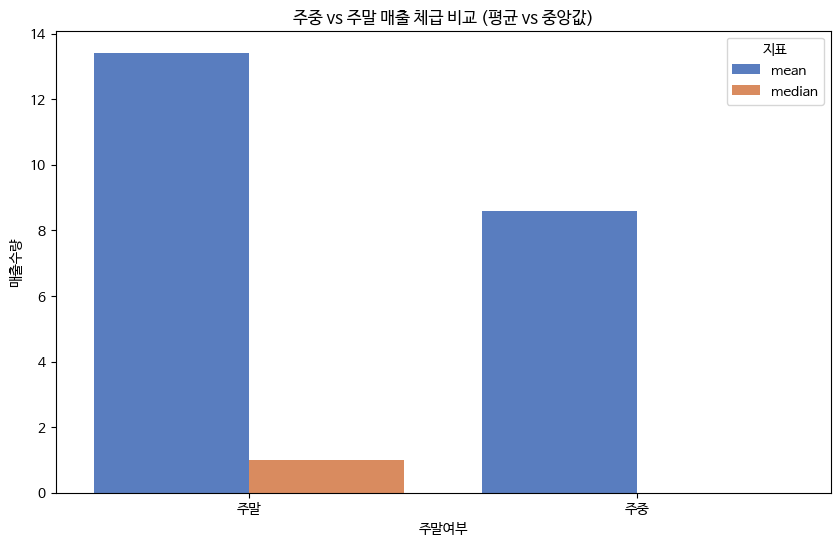

In [52]:
# 1. 기초 통계량 계산 (평균 vs 중앙값)
# '주말여부'는 금토일을 주말로 가정한 기준입니다.
usage_stats = train.groupby('주말여부')['매출수량'].agg(['mean', 'median', 'std', 'count']).reset_index()

# 2. 체급 차이 계산 (주말이 주중보다 몇 배 더 높은가?)
mean_diff = usage_stats.loc[usage_stats['주말여부']=='주말', 'mean'].values[0] / usage_stats.loc[usage_stats['주말여부']=='주중', 'mean'].values[0]
median_diff = usage_stats.loc[usage_stats['주말여부']=='주말', 'median'].values[0] / usage_stats.loc[usage_stats['주말여부']=='주중', 'median'].values[0]

print("### 주중/주말 매출 체급 분석 결과 ###")
print(usage_stats)
print(f"\n평균 기준 체급 차이: 약 {mean_diff:.2f}배")
print(f"중앙값 기준 체급 차이: 약 {median_diff:.2f}배")

# 3. 시각화 (평균과 중앙값을 동시에 비교)
plt.figure(figsize=(10, 6))
melted_stats = usage_stats.melt(id_vars='주말여부', value_vars=['mean', 'median'], var_name='지표', value_name='수량')

sns.barplot(data=melted_stats, x='주말여부', y='수량', hue='지표', palette='muted')
plt.title('주중 vs 주말 매출 체급 비교 (평균 vs 중앙값)')
plt.ylabel('매출수량')
plt.show()

In [53]:
# 1. 주중 데이터만 필터링
weekday_data = train[train['주말여부'] == '주중']
weekend_data = train[train['주말여부'] == '주말']

# 2. 주중 0 판매량 계산
weekday_total = len(weekday_data)
weekday_zero = len(weekday_data[weekday_data['매출수량'] == 0])
weekday_zero_ratio = (weekday_zero / weekday_total) * 100

# 3. 주말 0 판매량 계산 (비교용)
weekend_total = len(weekend_data)
weekend_zero = len(weekend_data[weekend_data['매출수량'] == 0])
weekend_zero_ratio = (weekend_zero / weekend_total) * 100

print(f"--- [주중(월-목) 판매량 0 분석] ---")
print(f"전체 데이터 수: {weekday_total:,}건")
print(f"판매량이 0인 건수: {weekday_zero:,}건")
print(f"판매량 0의 비중: {weekday_zero_ratio:.2f}%")

print(f"\n--- [주말(금-일) 판매량 0 분석] ---")
print(f"전체 데이터 수: {weekend_total:,}건")
print(f"판매량이 0인 건수: {weekend_zero:,}건")
print(f"판매량 0의 비중: {weekend_zero_ratio:.2f}%")

--- [주중(월-목) 판매량 0 분석] ---
전체 데이터 수: 58,672건
판매량이 0인 건수: 33,912건
판매량 0의 비중: 57.80%

--- [주말(금-일) 판매량 0 분석] ---
전체 데이터 수: 44,004건
판매량이 0인 건수: 20,136건
판매량 0의 비중: 45.76%


주중의 0의 비율이 50%가 넘음

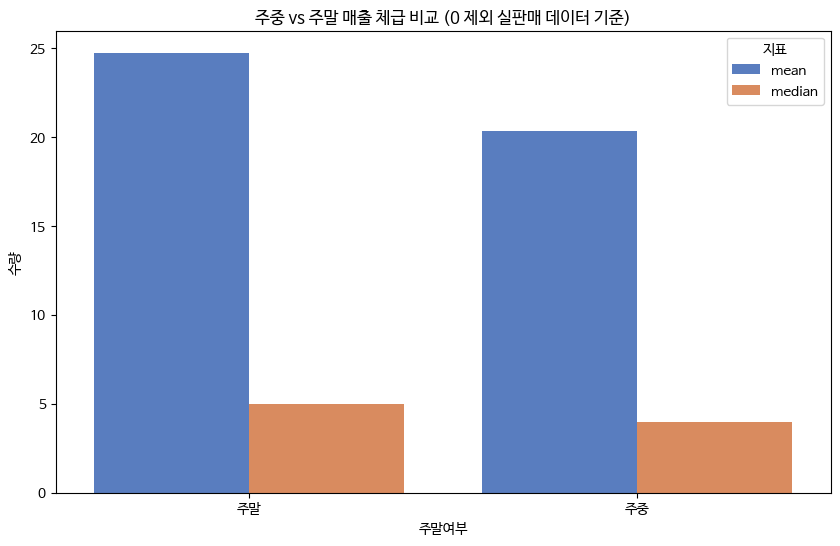

### 0을 제외한 실제 판매 발생 건 기준 ###
  주말여부       mean  median        std  count
0   주말  24.735252     5.0  67.549741  23868
1   주중  20.339216     4.0  48.419303  24760


In [54]:
# 매출수량이 0보다 큰 데이터만 추출하여 다시 분석
train_positive = train[train['매출수량'] > 0]

# 필터링된 데이터로 기초 통계량 계산
usage_stats_pos = train_positive.groupby('주말여부')['매출수량'].agg(['mean', 'median', 'std', 'count']).reset_index()

# 시각화
plt.figure(figsize=(10, 6))
melted_stats_pos = usage_stats_pos.melt(id_vars='주말여부', value_vars=['mean', 'median'], var_name='지표', value_name='수량')

sns.barplot(data=melted_stats_pos, x='주말여부', y='수량', hue='지표', palette='muted')
plt.title('주중 vs 주말 매출 체급 비교 (0 제외 실판매 데이터 기준)')
plt.show()

print("### 0을 제외한 실제 판매 발생 건 기준 ###")
print(usage_stats_pos)

/tmp/ipython-input-988548948.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['log_매출수량'] = np.log1p(train_filtered['매출수량'])


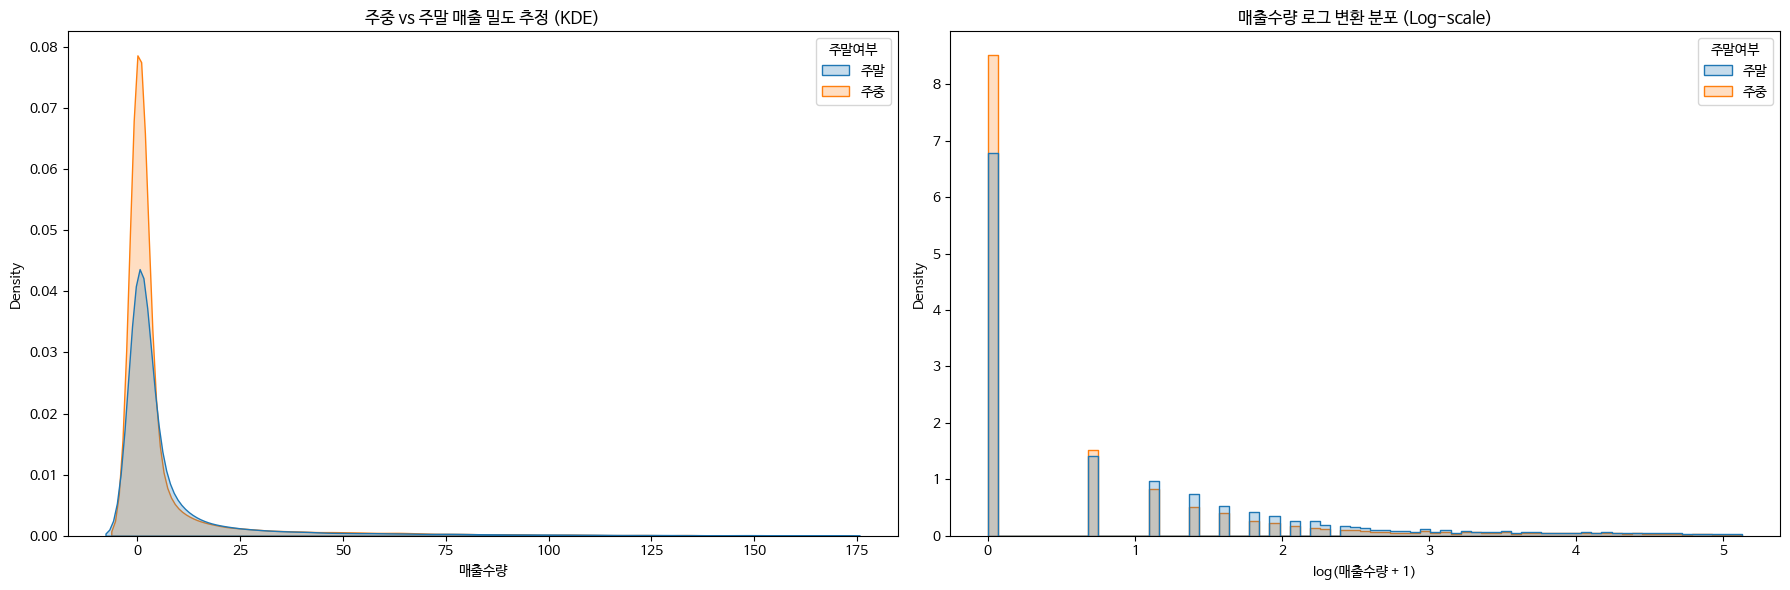

주중 매출 왜도: 9.45
주말 매출 왜도: 10.33


In [55]:
# 1. 상위 1% 극단적 이상치를 제외한 데이터 생성 (꼬리를 더 자세히 보기 위함)
limit = train['매출수량'].quantile(0.99)
train_filtered = train[train['매출수량'] <= limit]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# [그래프 A] 전체적인 분포 곡선 비교 (KDE Plot)
sns.kdeplot(data=train_filtered, x='매출수량', hue='주말여부', fill=True, ax=axes[0])
axes[0].set_title('주중 vs 주말 매출 밀도 추정 (KDE)')
axes[0].set_xlabel('매출수량')

# [그래프 B] 로그 변환 분포 (0 근처에 몰린 데이터를 펼쳐서 보기 위함)
# 0 값이 많으므로 log(x+1)을 사용합니다.
train_filtered['log_매출수량'] = np.log1p(train_filtered['매출수량'])
sns.histplot(data=train_filtered, x='log_매출수량', hue='주말여부', element='step', stat='density', common_norm=False, ax=axes[1])
axes[1].set_title('매출수량 로그 변환 분포 (Log-scale)')
axes[1].set_xlabel('log(매출수량 + 1)')

plt.tight_layout()
plt.show()

# 2. 왜도(Skewness) 수치 계산
print(f"주중 매출 왜도: {train[train['주말여부'] == '주중']['매출수량'].skew():.2f}")
print(f"주말 매출 왜도: {train[train['주말여부'] == '주말']['매출수량'].skew():.2f}")

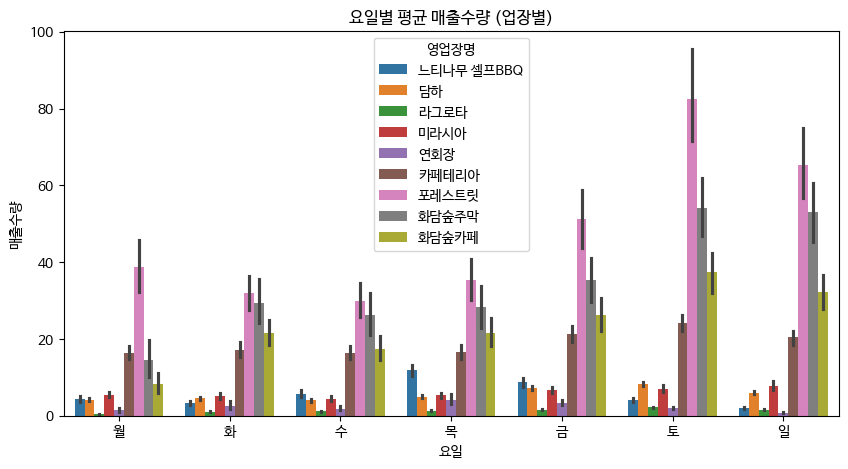

In [56]:
# 요일 X 업장 평균 매출
plt.figure(figsize=(10,5))
sns.barplot(
    data=train,
    x='요일',
    y='매출수량',
    hue='영업장명',
    estimator=np.mean
)
plt.title('요일별 평균 매출수량 (업장별)')
plt.xticks(range(7), ['월','화','수','목','금','토','일'])
plt.show()

###2, 요일별 메뉴 선호도

### 요일별 인기 메뉴 TOP 5 ###

[월요일]
영업장명_메뉴명
포레스트릿_꼬치어묵         8199
포레스트릿_떡볶이          6850
미라시아_브런치(대인) 주중    4399
포레스트릿_생수           4136
화담숲주막_해물파전         3746
Name: 월, dtype: int64

[화요일]
영업장명_메뉴명
화담숲주막_해물파전            7586
포레스트릿_꼬치어묵            6286
카페테리아_단체식 18000(신)    5543
포레스트릿_떡볶이             5135
포레스트릿_생수              3960
Name: 화, dtype: int64

[수요일]
영업장명_메뉴명
화담숲주막_해물파전            6835
포레스트릿_꼬치어묵            5845
포레스트릿_떡볶이             5061
카페테리아_단체식 18000(신)    4933
미라시아_브런치(대인) 주중       3828
Name: 수, dtype: int64

[목요일]
영업장명_메뉴명
화담숲주막_해물파전              7065
포레스트릿_꼬치어묵              7033
카페테리아_단체식 18000(신)      6129
포레스트릿_떡볶이               5914
느티나무 셀프BBQ_BBQ55(단체)    5377
Name: 목, dtype: int64

[금요일]
영업장명_메뉴명
포레스트릿_꼬치어묵            10846
포레스트릿_떡볶이              8878
화담숲주막_해물파전             8618
카페테리아_단체식 13000(신)     7455
포레스트릿_생수               7099
Name: 금, dtype: int64

[토요일]
영업장명_메뉴명
포레스트릿_꼬치어묵         17065
포레스트릿_떡볶이          13756
화담숲주막_해물파전         13326
포레스트릿_생수           1

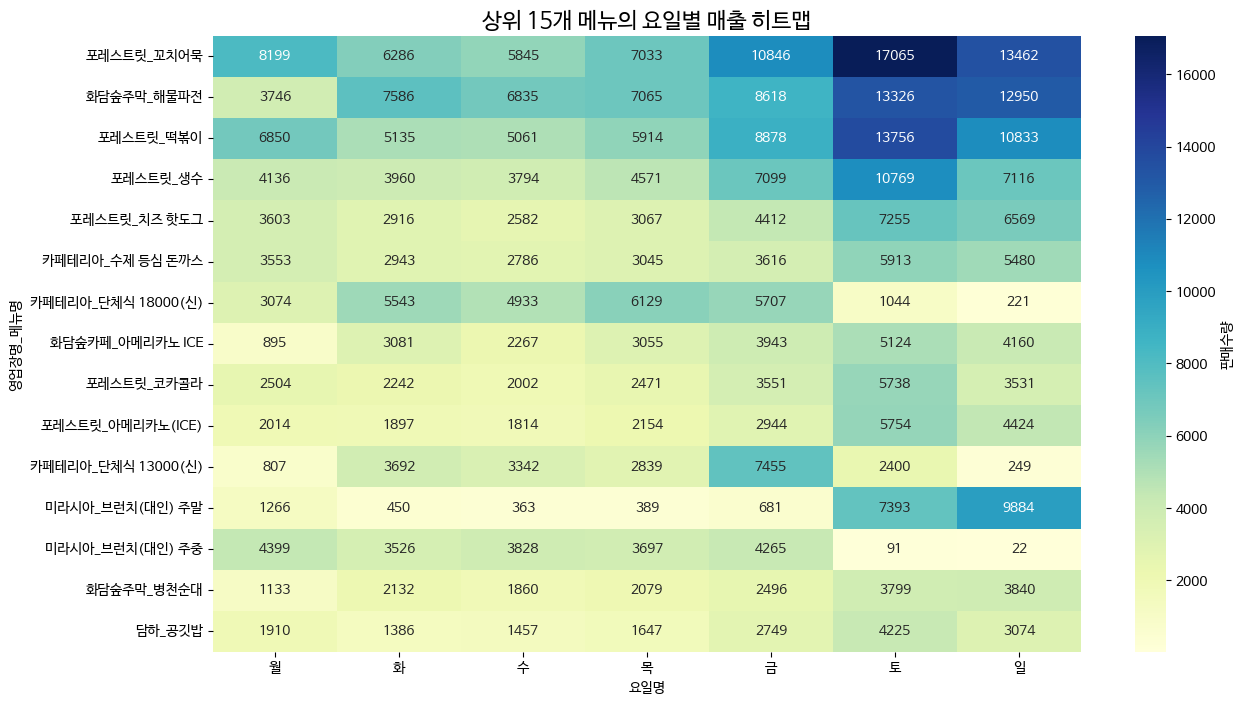

In [57]:
# 1. 요일별 메뉴 매출 합계 계산
menu_day_pivot = train.pivot_table(index='영업장명_메뉴명',
                                   columns='요일명',
                                   values='매출수량',
                                   aggfunc='sum').fillna(0)

# 2. 요일 순서 정렬 (월~일)
menu_day_pivot = menu_day_pivot[['월', '화', '수', '목', '금', '토', '일']]

# 3. 요일별 TOP 5 메뉴 출력
print("### 요일별 인기 메뉴 TOP 5 ###")
for col in menu_day_pivot.columns:
    top5 = menu_day_pivot[col].nlargest(5)
    print(f"\n[{col}요일]")
    print(top5)

# 4. 상위 15개 인기 메뉴의 요일별 집중도 히트맵 시각화
# 전체 매출 기준 상위 15개 메뉴 추출
top15_menu_names = train.groupby('영업장명_메뉴명')['매출수량'].sum().nlargest(15).index
hit_data = menu_day_pivot.loc[top15_menu_names]

plt.figure(figsize=(14, 8))
sns.heatmap(hit_data, annot=True, fmt=".0f", cmap='YlGnBu', cbar_kws={'label': '판매수량'})
plt.title('상위 15개 메뉴의 요일별 매출 히트맵', fontsize=16)
plt.show()


주말 매출이 평일의 2배. 단체식은 높은 판매량 유지하다가 주말에 감소. 브런치 주말에 10배 이상.

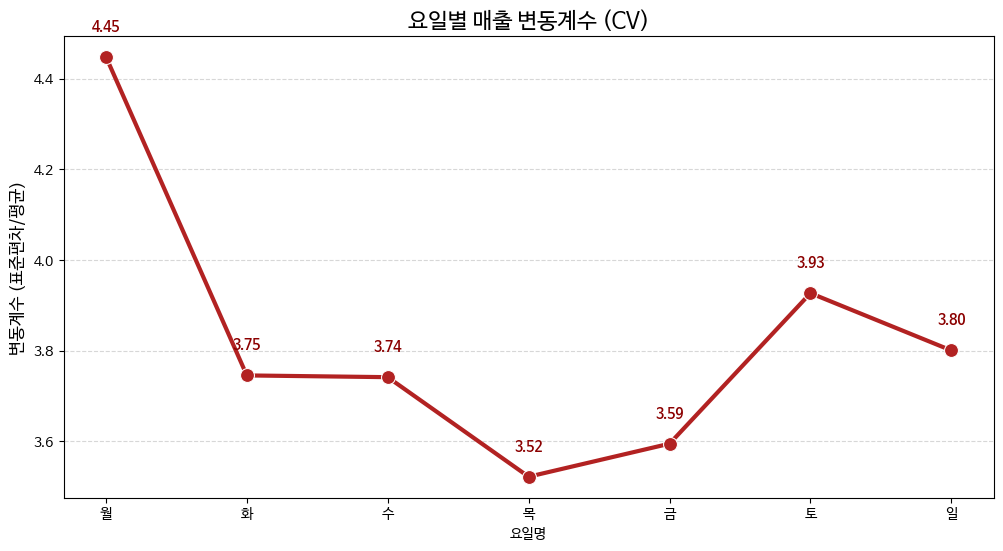

          mean        std      변동계수
요일명                                
월     7.767453  34.555656  4.448776
화     8.528293  31.941398  3.745345
수     8.064153  30.171959  3.741491
목     9.973275  35.123417  3.521754
금    12.255181  44.053100  3.594651
토    15.275770  59.986603  3.926912
일    12.718639  48.336025  3.800409


In [58]:
# 1. 요일별 기초 통계량 계산
volatility_stats = train.groupby('요일명')['매출수량'].agg(['mean', 'std']).reindex(['월', '화', '수', '목', '금', '토', '일'])

# 2. 변동계수(CV) 산출
volatility_stats['변동계수'] = volatility_stats['std'] / volatility_stats['mean']

# 3. 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=volatility_stats, x=volatility_stats.index, y='변동계수', marker='o', color='firebrick', linewidth=3, markersize=10)

# 값 표시
for i, val in enumerate(volatility_stats['변동계수']):
    plt.text(i, val + 0.05, f'{val:.2f}', ha='center', va='bottom', fontweight='bold', color='darkred')

plt.title('요일별 매출 변동계수 (CV)', fontsize=16)
plt.ylabel('변동계수 (표준편차/평균)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

print(volatility_stats)

월요일의 변동계수가 높은 것은, 매출의 절대량이 많아서가 아니라 평균 대비 편차가 극심하기 때문. 이는 월요일 매출이 특정 이벤트(단체 예약 등)에 극단적으로 의존하고 있음을 의미하며, 단순 시계열 예측보다는 이벤트 기반의 피처 엔지니어링이 필수적인 요일임을 시사.

In [59]:
# 1. 일요일과 월요일 데이터만 추출
sun_mon_df = train[train['요일명'].isin(['일', '월'])]

# 2. 요일별 메뉴 매출 합계 계산
comparison = sun_mon_df.groupby(['요일명', '영업장명_메뉴명'])['매출수량'].sum().reset_index()

# 3. 요일별로 랭킹 매기기
comparison['순위'] = comparison.groupby('요일명')['매출수량'].rank(ascending=False, method='min')

# 4. 일요일 TOP 10과 월요일 TOP 10 비교 테이블 생성
sun_top10 = comparison[comparison['요일명']=='일'].sort_values('순위').head(10)[['영업장명_메뉴명', '매출수량']]
mon_top10 = comparison[comparison['요일명']=='월'].sort_values('순위').head(10)[['영업장명_메뉴명', '매출수량']]

# 인덱스를 1~10으로 맞춰서 나란히 보기
sun_top10.index = range(1, 11)
mon_top10.index = range(1, 11)

print("### [일요일 vs 월요일] 인기 메뉴 TOP 10 비교 ###")
result = pd.concat([sun_top10, mon_top10], axis=1)
result.columns = ['일요일 메뉴', '일요일 수량', '월요일 메뉴', '월요일 수량']
display(result)

### [일요일 vs 월요일] 인기 메뉴 TOP 10 비교 ###


,일요일 메뉴,일요일 수량,월요일 메뉴,월요일 수량
1,포레스트릿_꼬치어묵,13462,포레스트릿_꼬치어묵,8199
2,화담숲주막_해물파전,12950,포레스트릿_떡볶이,6850
3,포레스트릿_떡볶이,10833,미라시아_브런치(대인) 주중,4399
4,미라시아_브런치(대인) 주말,9884,포레스트릿_생수,4136
5,포레스트릿_생수,7116,화담숲주막_해물파전,3746
6,포레스트릿_치즈 핫도그,6569,포레스트릿_치즈 핫도그,3603
7,카페테리아_수제 등심 돈까스,5480,카페테리아_수제 등심 돈까스,3553
8,포레스트릿_아메리카노(ICE),4424,카페테리아_단체식 18000(신),3074
9,화담숲카페_아메리카노 ICE,4160,포레스트릿_코카콜라,2504
10,화담숲주막_병천순대,3840,카페테리아_돼지고기 김치찌개,2135


/tmp/ipython-input-1997536078.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=zero_prob_eda.index, y=zero_prob_eda.values, palette='Greys_r')


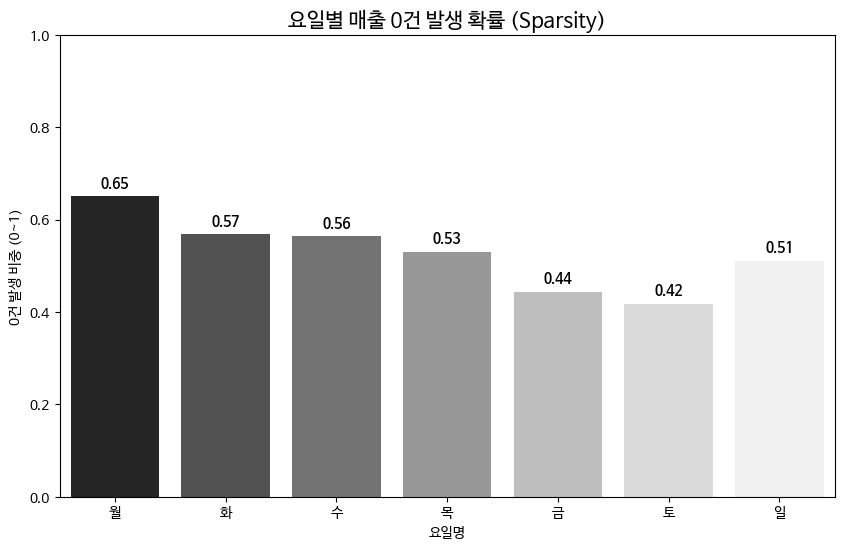

In [60]:
# 1. 매출이 0인 데이터 여부를 나타내는 컬럼 생성
train['is_zero_sales'] = (train['매출수량'] <= 0).astype(int)

# 2. 요일별 '0 판매' 비중 계산
zero_prob_eda = train.groupby('요일명')['is_zero_sales'].mean().reindex(['월', '화', '수', '목', '금', '토', '일'])

# 3. 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=zero_prob_eda.index, y=zero_prob_eda.values, palette='Greys_r')
plt.title('요일별 매출 0건 발생 확률 (Sparsity)', fontsize=15)
plt.ylabel('0건 발생 비중 (0~1)')
plt.ylim(0, 1)

# 값 표시
for i, v in enumerate(zero_prob_eda.values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')

plt.show()

# *파생변수*

In [61]:
# 1. 데이터를 날짜순으로 정렬 (과거 평균을 구하기 위해 필수)
train = train.sort_values('영업일자')

# 2. 월요일 데이터만 추출해서 '누적 과거 평균' 계산
mon_data = train[train['요일'] == 0].copy()
# expanding().mean()은 현재 행 이전까지의 모든 데이터 평균을 구합니다.
# 단, 현재 날짜의 매출이 포함되지 않게 shift(1)을 해줍니다.
mon_data['past_mon_mean'] = mon_data['매출수량'].expanding().mean().shift(1)

# 3. 원본 데이터에 과거 평균값 합치기
train = pd.merge(train, mon_data[['영업일자', 'past_mon_mean']], on='영업일자', how='left')

# 4. 지수 계산: (현재 매출) / (과거 월요일들의 평균)
# 첫 번째 월요일은 과거 데이터가 없으므로 결측치가 생길 수 있어 fillna(1) 처리
train['mon_event_intensity'] = (train['매출수량'] / train['past_mon_mean']).fillna(1.0)

# 확인
print(train[train['요일']==0][['영업일자', '매출수량', 'past_mon_mean', 'mon_event_intensity']].head())

          영업일자  매출수량  past_mon_mean  mon_event_intensity
193 2023-01-02    17            NaN             1.000000
194 2023-01-02    17      17.000000             1.000000
195 2023-01-02    17       8.500000             2.000000
196 2023-01-02    17       5.666667             3.000000
197 2023-01-02    17       4.500000             3.777778


mon_event_intensity : 월요일 이상치 강도 지수, (해당 날짜의 매출수량) / (과거 월요일들의 평균 매출수량)

##4. 월별

In [62]:
train_clean = train[train['매출수량'] >= 0].copy()

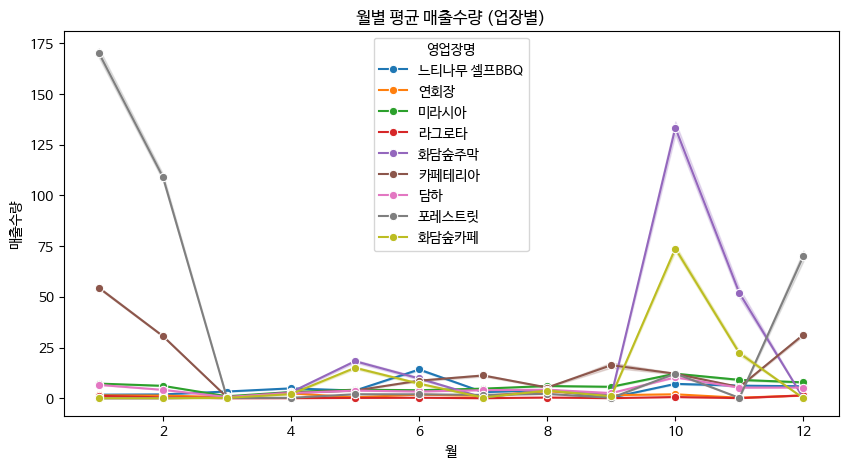

In [63]:
# 월별 패턴(계절성)
plt.figure(figsize=(10,5))
sns.lineplot(
    data=train,
    x='월',
    y='매출수량',
    hue='영업장명',
    estimator=np.mean,
    marker='o'
)
plt.title('월별 평균 매출수량 (업장별)')
plt.show()

월별 전체 매출 수량 추이
월별 영업장별 매출 비중

매출수량 max = 1372 과도히 큼.

- 단체 주문?
- 성수기?

In [64]:
# 상위 데이터 확인
top_sales = train_clean.sort_values(by='매출수량', ascending=False).head(20)
print("--- 상위 매출 데이터 확인 ---")
print(top_sales[['영업장명','메뉴명', '영업일자', '매출수량']])

--- 상위 매출 데이터 확인 ---
          영업장명   메뉴명       영업일자  매출수량
2073787  포레스트릿  꼬치어묵 2024-01-13  1372
2150726  포레스트릿  꼬치어묵 2024-01-27  1329
2112375  포레스트릿  꼬치어묵 2024-01-20  1235
2150748  포레스트릿   떡볶이 2024-01-27  1200
2073967  포레스트릿   떡볶이 2024-01-13  1174
191864   포레스트릿  꼬치어묵 2023-02-04  1165
129904   포레스트릿  꼬치어묵 2023-01-23  1130
130021   포레스트릿  꼬치어묵 2023-01-23  1130
129897   포레스트릿  꼬치어묵 2023-01-23  1130
129895   포레스트릿  꼬치어묵 2023-01-23  1130
129896   포레스트릿  꼬치어묵 2023-01-23  1130
129893   포레스트릿  꼬치어묵 2023-01-23  1130
129892   포레스트릿  꼬치어묵 2023-01-23  1130
129891   포레스트릿  꼬치어묵 2023-01-23  1130
129894   포레스트릿  꼬치어묵 2023-01-23  1130
129921   포레스트릿  꼬치어묵 2023-01-23  1130
129920   포레스트릿  꼬치어묵 2023-01-23  1130
129919   포레스트릿  꼬치어묵 2023-01-23  1130
130052   포레스트릿  꼬치어묵 2023-01-23  1130
130051   포레스트릿  꼬치어묵 2023-01-23  1130


전부 포레스트릿 기록. 1~2월의 꼬치어묵&떡볶이에 집중되어 있음.

In [65]:
# 상위 100개 데이터 추출
top_100 = train_clean.sort_index().sort_values(by='매출수량', ascending=False).head(100)

# 상위 100개 안에 어떤 영업장이 몇 개나 있는지 확인
print("상위 100개 데이터의 영업장별 분포")
print(top_100['영업장명'].value_counts())

# 상위 100개 안에 어떤 메뉴가 몇 개나 있는지 확인
print("\n 상위 100개 데이터의 메뉴별 분포")
print(top_100['메뉴명'].value_counts())

상위 100개 데이터의 영업장별 분포
영업장명
포레스트릿    100
Name: count, dtype: int64

 상위 100개 데이터의 메뉴별 분포
메뉴명
꼬치어묵    98
떡볶이      2
Name: count, dtype: int64


In [66]:
# 포레스트릿을 제외한 매장들의 상위 10개 데이터
non_forest = train_clean[train_clean['영업장명'] != '포레스트릿']
print(non_forest.sort_values(by='매출수량', ascending=False).head(10))

              영업일자            영업장명_메뉴명  매출수량   영업장명             메뉴명  요일    연도  \
421971  2023-03-16  연회장_Regular Coffee   800    연회장  Regular Coffee   3  2023   
1438823 2023-09-18          카페테리아_오픈푸드   780  카페테리아            오픈푸드   0  2023   
1438822 2023-09-18          카페테리아_오픈푸드   780  카페테리아            오픈푸드   0  2023   
1438830 2023-09-18          카페테리아_오픈푸드   780  카페테리아            오픈푸드   0  2023   
1438829 2023-09-18          카페테리아_오픈푸드   780  카페테리아            오픈푸드   0  2023   
1438828 2023-09-18          카페테리아_오픈푸드   780  카페테리아            오픈푸드   0  2023   
1438827 2023-09-18          카페테리아_오픈푸드   780  카페테리아            오픈푸드   0  2023   
1438826 2023-09-18          카페테리아_오픈푸드   780  카페테리아            오픈푸드   0  2023   
1438825 2023-09-18          카페테리아_오픈푸드   780  카페테리아            오픈푸드   0  2023   
1438824 2023-09-18          카페테리아_오픈푸드   780  카페테리아            오픈푸드   0  2023   

         월   일   주  ... 최종_Top  최종_Sub   음식_분류  Day_Type      Season  메뉴_카테고리  \
421971   3  16  11  ...    

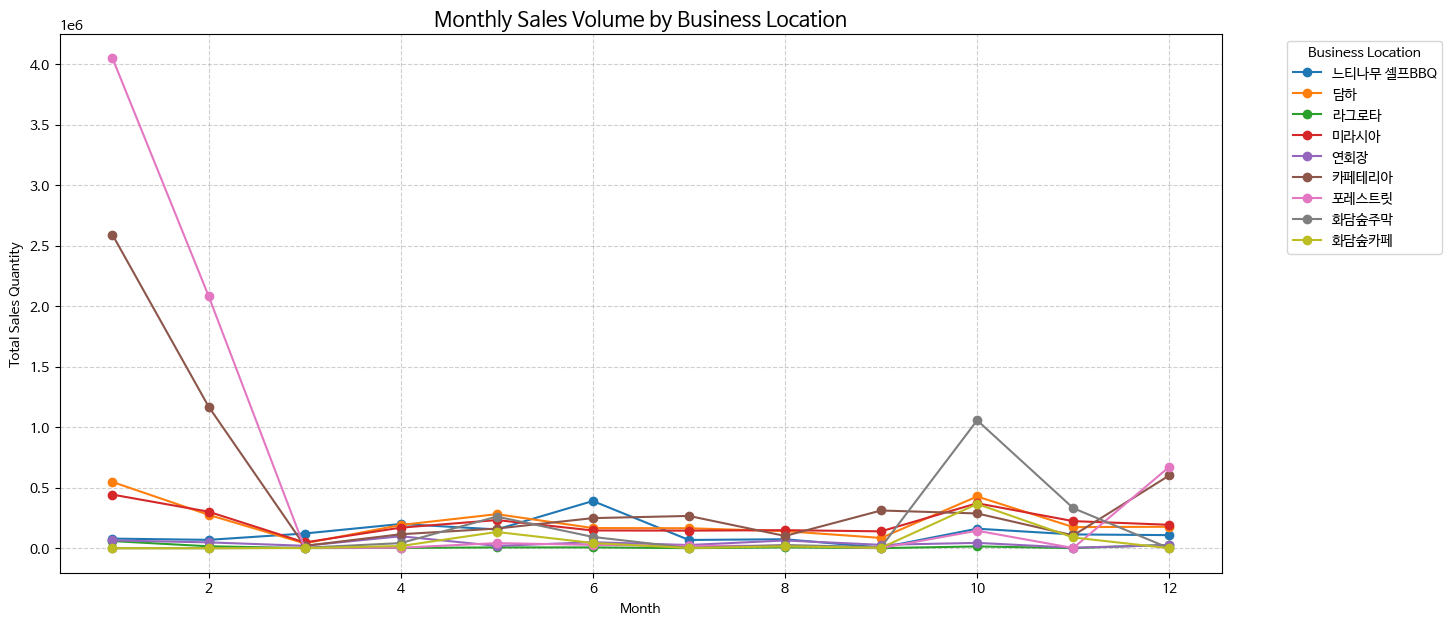

In [67]:
# 월별, 영업장별 매출 합계 계산
monthly_sales = train_clean.groupby(['월', '영업장명'])['매출수량'].sum().unstack().fillna(0)

# 시각화 (영업장별 월별 매출 추이)
monthly_sales.plot(kind='line', marker='o', figsize=(15, 7))
plt.title('Monthly Sales Volume by Business Location', fontsize=15)
plt.ylabel('Total Sales Quantity')
plt.xlabel('Month')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Business Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

1월 매출이 제일 높음
(포레스트릿, 카페테리아 상위권)
전반적으로 겨울 매출에서 강세 보임-겨울철 액티비티와 강한 연관 있을 것 같음

4월, 10월에서 화담숲주막의 매출 상승
화담숲카페도 동반 상승(이름이 비슷하니까 근처에 위치하나 싶음)

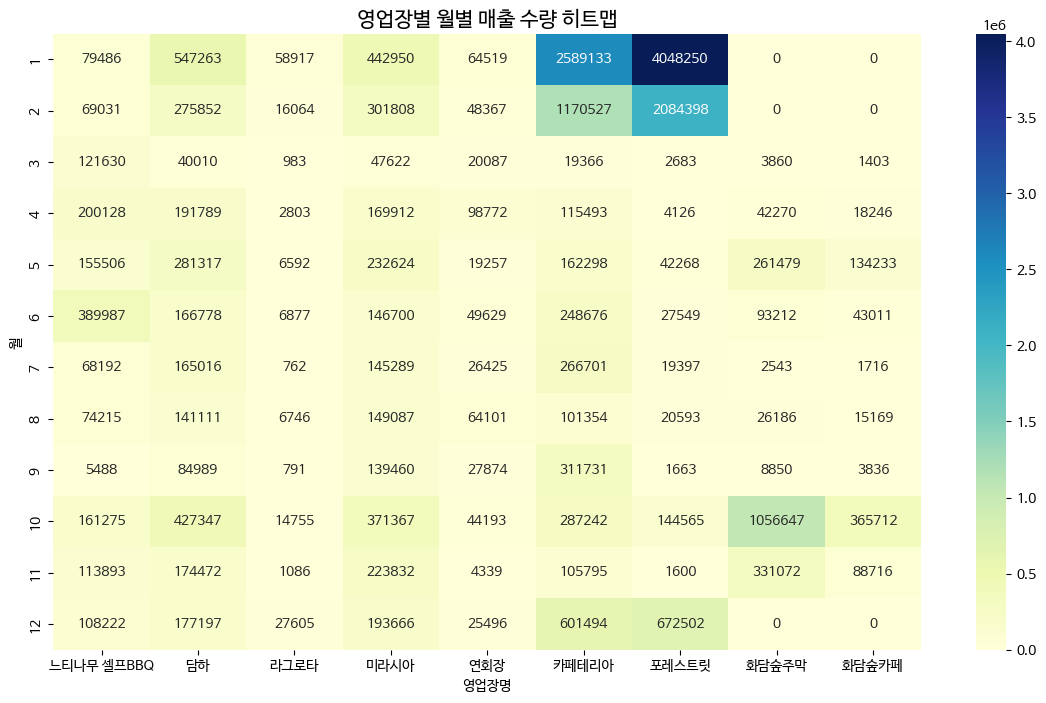

In [68]:
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.heatmap(monthly_sales, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('영업장별 월별 매출 수량 히트맵', fontsize=15)
plt.show()

계절성 패턴 강하게 보임

겨울시즌(12~2월) : 포레스트릿, 카페테리아
- 압도적 매출 상승
- 꼬치어묵, 떡볶이 등 겨울 액티비티 관련성 추측

가을 시즌(10~11월): 화담숲주막, 화담숲카페
- 매출 급증
- 단풍시즌 화담숲 방문객이 주막-카페 이용하는듯?
- 해물파전 등 계절성 메뉴
- 특이점: 겨울시즌 화담숲주막/화담숲카페는 매출수량 0, 동절기 휴장 가능성 추측

봄 시즌(4월): 화담숲주막, 화담숲카페
- 봄꽃 시즌인가 싶음

정리
- 월별 분석시 특정 매장의 특정 메뉴가 유의미한 매출 상승 지표 가짐.
- 월별 따로 움직이기보단 2-3개월의 흐름을 가지고 계절성 패턴을 가짐
- 계절별 수요 변화를 잡을 수 있도록 파생변수나 가중치 반영해주면 좋을 것 같음

파생변수 생성
- '메뉴_판매순위': 월별 판매순위
해당 월 내에서 해당 메뉴의 판매 순위
계절에 따른 고객의 선호도 변화 추적

- '메뉴_비중': 메뉴 비중(구성비)
해당 월의 전체 판매량 대비 해당 메뉴의 판매 비중
전체적인 업장 흐름 속 메뉴의 인기도 파악에 활용.
특정 메뉴의 판매량이 절대적으로 감소하더라도 판매 비중이 유지된다면 여전히 인기메뉴로 볼 수 있음. 단순 수량 변화보다 안정적 예측 가능

- '비중_증감폭': 전월 대비 구성비의 증감폭
인기가 상승중인지 하락중인지 추세 반영(계절 시작했는지 계절 끝나가는 중인지)

- '주말여부'
전처리 단계에서 이미 생성함. 이진변수(평일은 0, 주말은 1)

- '휴점여부'
7일 연속 판매량이 0일 경우 휴점'으로 판단하는 이동창(Rolling Window) 방식으로 생성.

In [69]:
# 월별 메뉴별 총 판매량 집계부터
monthly_agg = train_clean.groupby(['연도', '월', '영업장명', '메뉴명'])['매출수량'].sum().reset_index()
monthly_agg.rename(columns={'매출수량': '월간_메뉴_총판매량'}, inplace=True)

# 월별 전체 판매량 계산 후 구성비 계산
total_monthly_sales = monthly_agg.groupby(['연도', '월', '영업장명'])['월간_메뉴_총판매량'].transform('sum')
monthly_agg['메뉴_비중'] = monthly_agg['월간_메뉴_총판매량'] / total_monthly_sales

# 월별 판매 순위 생성
# 동일할 경우 'min' 방식으로 매김
monthly_agg['메뉴_판매순위'] = monthly_agg.groupby(['연도', '월', '영업장명'])['월간_메뉴_총판매량'].rank(ascending=False, method='min')

# 전월 대비 구성비의 증감폭
# 메뉴별로 시계열 순서에 따라 이전 행과의 차이 계산
monthly_agg = monthly_agg.sort_values(['영업장명', '메뉴명', '연도', '월'])
monthly_agg['비중_증감폭'] = monthly_agg.groupby(['영업장명', '메뉴명'])['메뉴_비중'].diff().fillna(0)

In [70]:
# 기존 데이터프레임에 결합
# '영업장명'과 '메뉴명'을 키로 각 일자별 데이터에 매칭
df_final = pd.merge(train_clean,
                    monthly_agg[['연도', '월', '영업장명', '메뉴명', '메뉴_비중', '메뉴_판매순위', '비중_증감폭']],
                    on=['연도', '월', '영업장명', '메뉴명'], how='left')

'휴점여부' 파생변수 추가함

In [71]:
def add_detailed_off_status(df, window=7):
    # 분석의 정확성을 위해 날짜순 정렬
    df = df.sort_values(['영업장명', '영업일자'])
    df['휴점여부'] = 0

    # 영업장별로 루프를 돌며 판단 (해당 영업장이 문 닫으면 모든 메뉴 판매량이 0이 될 것을 가정함)
    for shop in df['영업장명'].unique():
        # 해당 영업장의 일자별 총 매출 수량 계산
        shop_daily = df[df['영업장명'] == shop].groupby('영업일자')['매출수량'].sum().reset_index()

        # window 기간 동안 매출 합계가 0인지 확인
        is_zero = shop_daily['매출수량'] == 0
        rolling_zero = is_zero.rolling(window=window).sum() == window

        # 휴점으로 판단된 날짜들 추출
        off_dates = shop_daily.loc[rolling_zero, '영업일자']

        # 원본 데이터프레임에 반영 - 특정 날짜에 해당 영업장의 모든 메뉴 행을 휴점으로 표시
        for off_date in off_dates:
            # rolling이 끝나는 지점부터 역으로 window만큼 휴점 처리
            start_date = off_date - pd.Timedelta(days=window-1)
            mask = (df['영업장명'] == shop) & (df['영업일자'] >= start_date) & (df['영업일자'] <= off_date)
            df.loc[mask, '휴점여부'] = 1

    return df

# 적용
df_final = add_detailed_off_status(df_final)

In [72]:
df_final.head()

,영업일자,영업장명_메뉴명,매출수량,영업장명,메뉴명,요일,연도,월,일,주,...,Season,메뉴_카테고리,요일명,is_zero_sales,past_mon_mean,mon_event_intensity,메뉴_비중,메뉴_판매순위,비중_증감폭,휴점여부
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,6,2023,1,1,52,...,겨울 (12-2월),행사/단체,일,1,NaN,1.0,0.016222,8.0,0.0,0
12,2023-01-01,느티나무 셀프BBQ_잔디그늘집 대여료 (6인석),0,느티나무 셀프BBQ,잔디그늘집 대여료 (6인석),6,2023,1,1,52,...,겨울 (12-2월),대여/공간,일,1,NaN,1.0,0.000020,16.0,0.0,0
14,2023-01-01,느티나무 셀프BBQ_콜라 (단체),0,느티나무 셀프BBQ,콜라 (단체),6,2023,1,1,52,...,겨울 (12-2월),행사/단체,일,1,NaN,1.0,0.095975,4.0,0.0,0
20,2023-01-01,"느티나무 셀프BBQ_대여료 30,000원",9,느티나무 셀프BBQ,"대여료 30,000원",6,2023,1,1,52,...,겨울 (12-2월),대여/공간,일,0,NaN,1.0,0.088794,5.0,0.0,0
27,2023-01-01,느티나무 셀프BBQ_BBQ55(단체),0,느티나무 셀프BBQ,BBQ55(단체),6,2023,1,1,52,...,겨울 (12-2월),행사/단체,일,1,NaN,1.0,0.195955,2.0,0.0,0
